# Students Social Media Behavior Analysis

## Step 1: Imports and global settings

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import requests
from io import BytesIO

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

url = 'https://raw.githubusercontent.com/GirottoLLS/Social-Media-and-Academic-Impact/refs/heads/main/Data/Students%20Social%20Media%20Addiction.csv'
response = requests.get(url)

## Step 2: Load and prepare the data

### Load dataset, rename necessary variables and drop unnecessary columns. Then a quick data overview

In [8]:
df = pd.read_csv(url)
df.drop(columns=['Country'], errors='ignore', inplace=True)
df['SleepHours'] = df['Sleep_Hours_Per_Night']
df['DailyUsageHours'] = df['Avg_Daily_Usage_Hours']
df.drop(columns=['Sleep_Hours_Per_Night', 'Avg_Daily_Usage_Hours'], inplace=True)

print("--> Data Info:")
df.info()
print("\n--> Descriptive stats for numerical columns:")
df.select_dtypes(include=[np.number]).describe().T

--> Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    705 non-null    int64  
 1   Age                           705 non-null    int64  
 2   Gender                        705 non-null    object 
 3   Academic_Level                705 non-null    object 
 4   Most_Used_Platform            705 non-null    object 
 5   Affects_Academic_Performance  705 non-null    object 
 6   Mental_Health_Score           705 non-null    int64  
 7   Relationship_Status           705 non-null    object 
 8   Conflicts_Over_Social_Media   705 non-null    int64  
 9   Addicted_Score                705 non-null    int64  
 10  SleepHours                    705 non-null    float64
 11  DailyUsageHours               705 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 

,count,mean,std,min,25%,50%,75%,max
Student_ID,705.0,353.000000,203.660256,1.0,177.0,353.0,529.0,705.0
Age,705.0,20.659574,1.399217,18.0,19.0,21.0,22.0,24.0
Mental_Health_Score,705.0,6.226950,1.105055,4.0,5.0,6.0,7.0,9.0
Conflicts_Over_Social_Media,705.0,2.849645,0.957968,0.0,2.0,3.0,4.0,5.0
Addicted_Score,705.0,6.436879,1.587165,2.0,5.0,7.0,8.0,9.0
SleepHours,705.0,6.868936,1.126848,3.8,6.0,6.9,7.7,9.6
DailyUsageHours,705.0,4.918723,1.257395,1.5,4.1,4.8,5.8,8.5


# Step 3: Exploratory plots - categorical variables

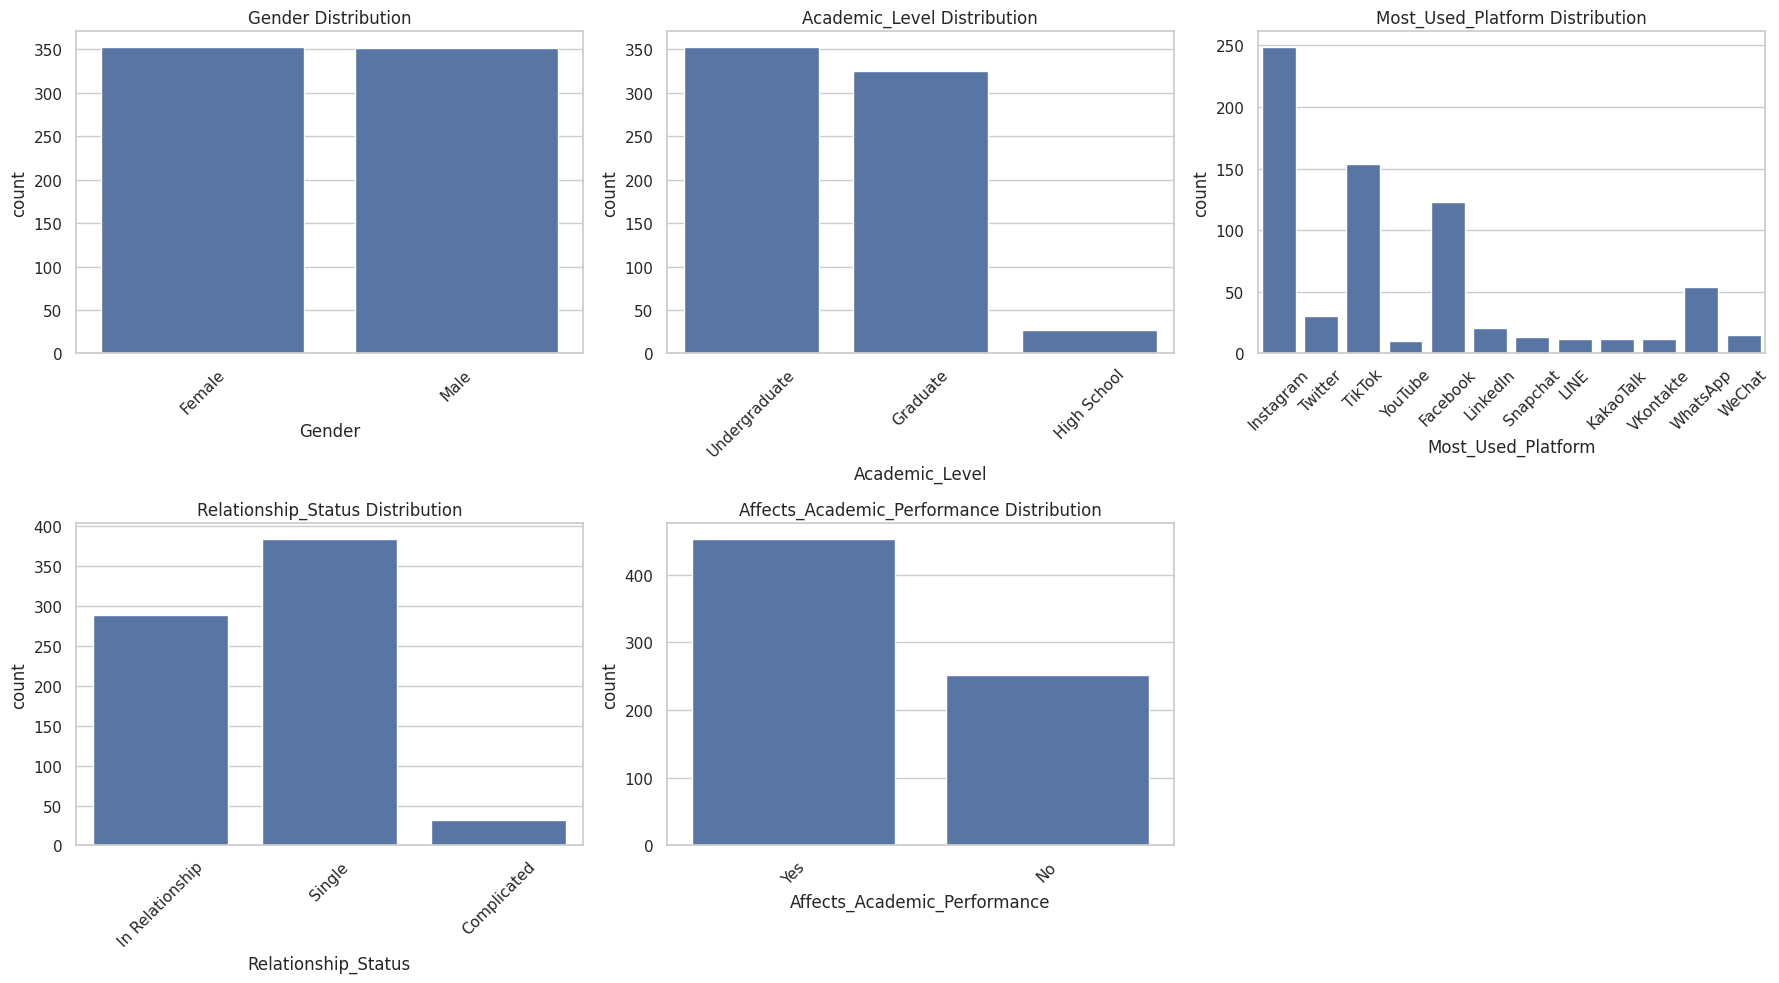

In [9]:
categorical = ['Gender', 'Academic_Level', 'Most_Used_Platform', 'Relationship_Status', 'Affects_Academic_Performance']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, col in zip(axes.flatten(), categorical):
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(f"{col} Distribution")
    ax.tick_params(axis='x', rotation=45)
fig.delaxes(axes.flatten()[-1])
plt.tight_layout(); plt.show()

### Male and female studens are equaly represented in this analysis, and most aregraduate and undergraduate students. Instagram, TikTok, Facebook and Whatsapp are the prefered social media, remaining platforms are minoritary. Majority of participants reported negative impact on academic performance due to social media.

# Step 5: Exploratory plots - numeric variables

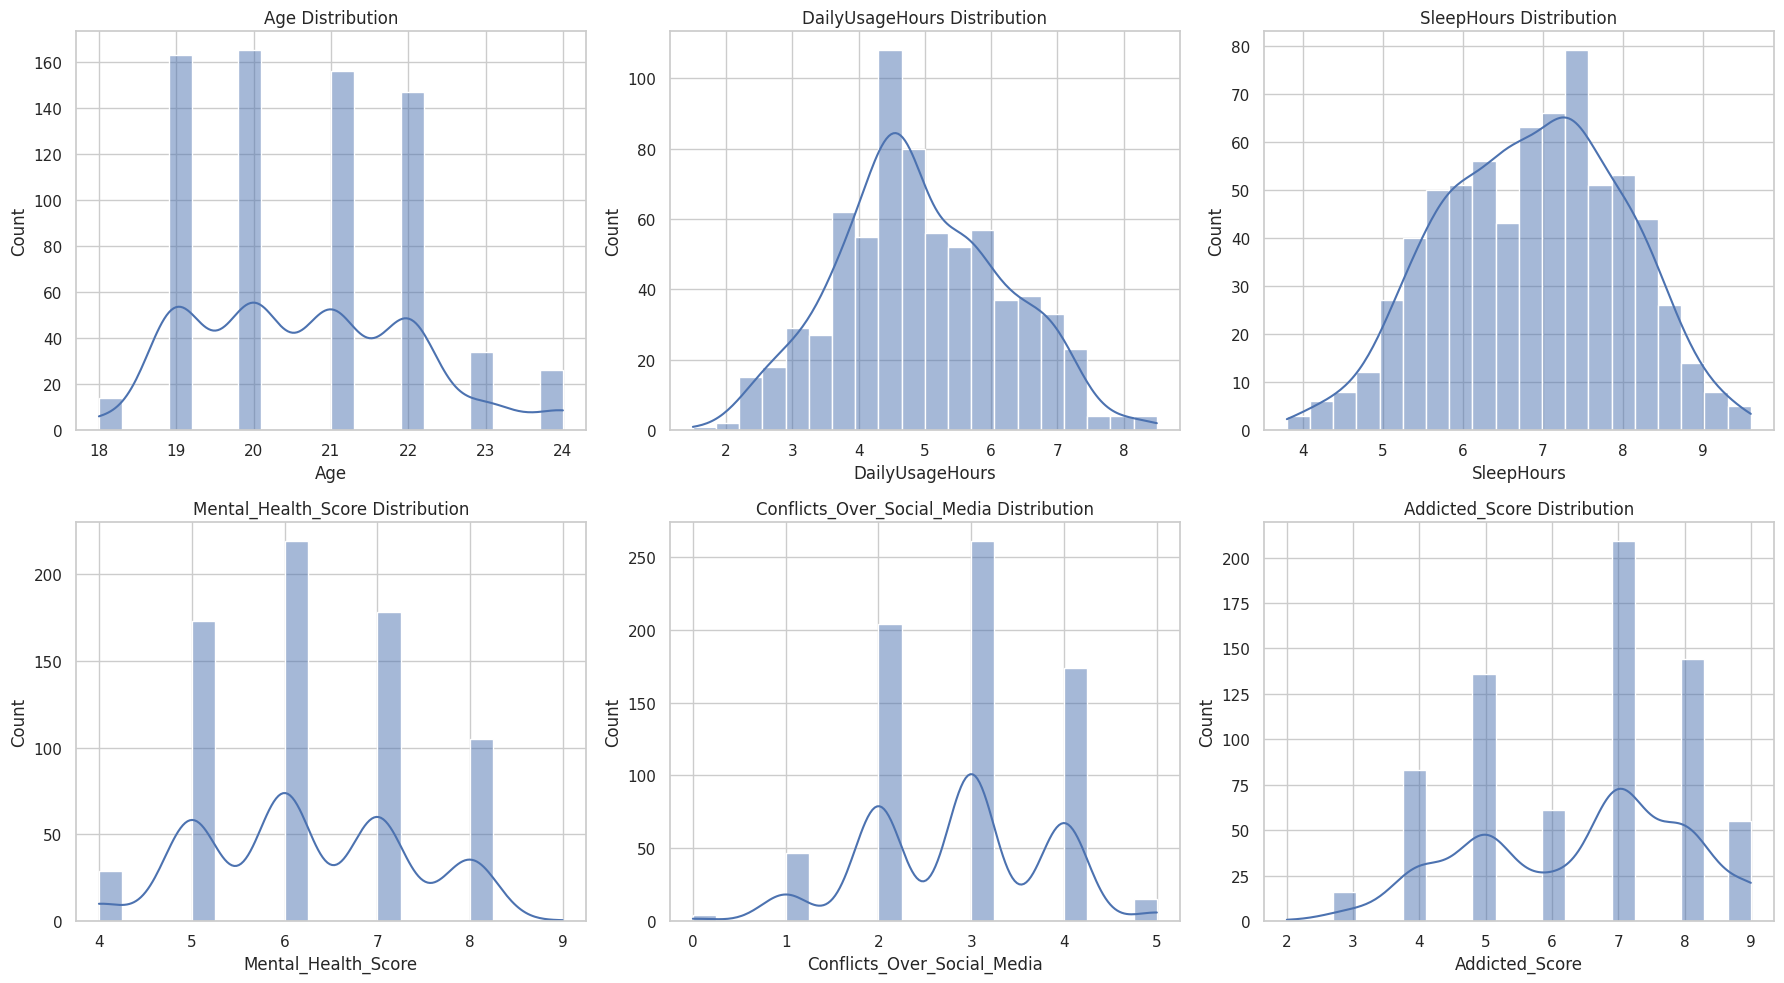

In [10]:
numeric = ['Age', 'DailyUsageHours', 'SleepHours', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Addicted_Score']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, col in zip(axes.flatten(), numeric):
    sns.histplot(df[col], kde=True, bins=20, ax=ax)
    ax.set_title(f"{col} Distribution")
plt.tight_layout(); plt.show()

### Participants mostly range from 19 to 22 years old and report mental health score of 5 to 8, on a scale of 0 to 10. Daily use of social media and hours of sleep follow a generally normal distribution that shows students interact with the platforms 4.5 hours a day and sleep 7 hours, on average. Most participants report entering arguments on social media and disclose dependency on their use.

# Step 6: Platform impact on sleep and mental health

### Sleep hours as target variable for Favorite Platform. Does specific platforms impact sleep patterns differently?

### Mental health score as target variable for favorite platform. Platform preference suggests mental health struggle?

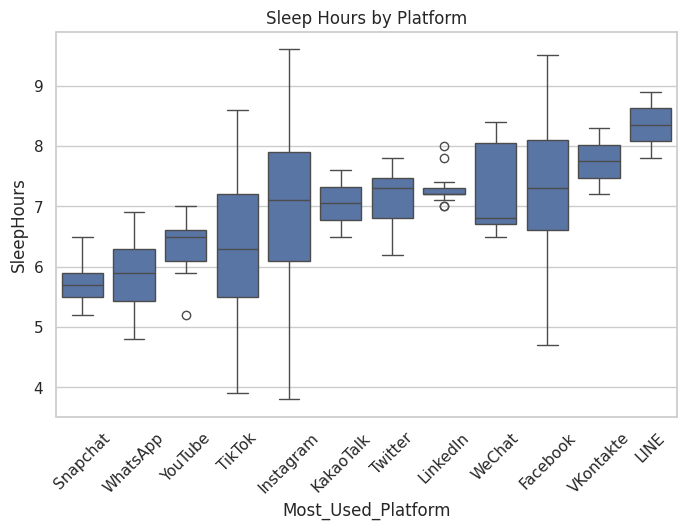

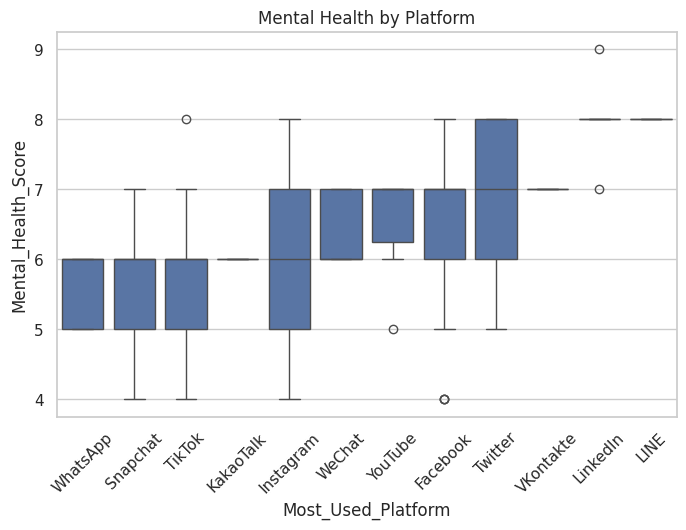

In [11]:
# Sleep hours as target variable for Favorite Platform
order_sleep = df.groupby('Most_Used_Platform')['SleepHours'].mean().sort_values().index
sns.boxplot(x='Most_Used_Platform', y='SleepHours', data=df, order=order_sleep)
plt.xticks(rotation=45); plt.title('Sleep Hours by Platform'); plt.show()

# Mental health score as target variable for Favorite Platform
order_mh = df.groupby('Most_Used_Platform')['Mental_Health_Score'].mean().sort_values().index
sns.boxplot(x='Most_Used_Platform', y='Mental_Health_Score', data=df, order=order_mh)
plt.xticks(rotation=45); plt.title('Mental Health by Platform'); plt.show()

# Step 7: Age vs addiction and mental health

### Is self reported adicion a product of age? Followed by a similar question on wheter mental health is correlated to age.

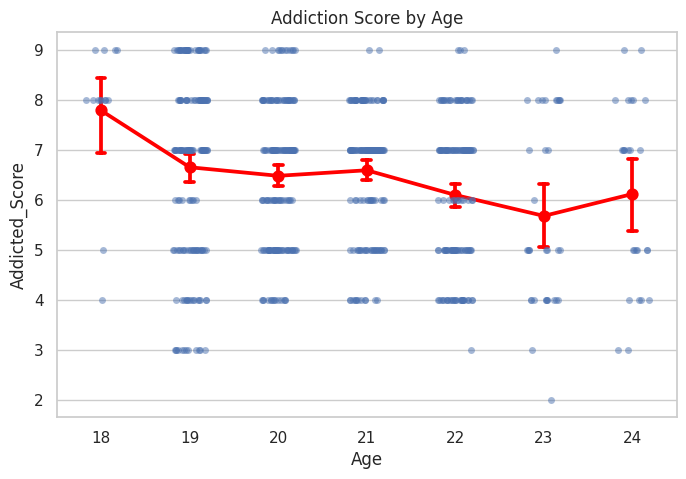

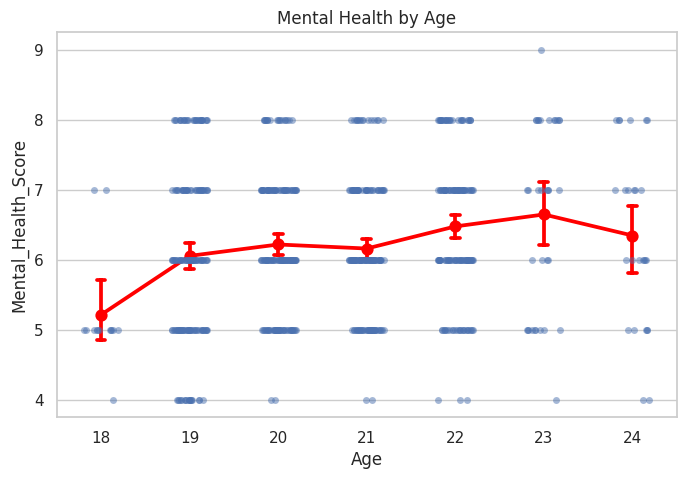

In [13]:
# Addiction score as functon of Age
sns.stripplot(x='Age', y='Addicted_Score', data=df, jitter=0.2, alpha=0.5)
sns.pointplot(x='Age', y='Addicted_Score', data=df, color='red', capsize=0.1)
plt.title('Addiction Score by Age'); plt.show()

# Mental health score as functon of Age
sns.stripplot(x='Age', y='Mental_Health_Score', data=df, jitter=0.2, alpha=0.5)
sns.pointplot(x='Age', y='Mental_Health_Score', data=df, color='red', capsize=0.1)
plt.title('Mental Health by Age'); plt.show()

### Social media adsiction and mental health seem to both be factors associated with age, but with oposite correlations. At the same time addiction is stronger, on younger students, mental health is at it's lowest. This troublesome period seems to get better with age, as 23 and 24 yrs old reported the best wellbeing score on these metrics

# Step 8: Relationship status impact

### Does daily use of social media impact relationship status? Or perhaps mental health scores would impacts it? Majority of participants reported being single or in a relationship, with interestingly a minority group reporting only "it's complicated"

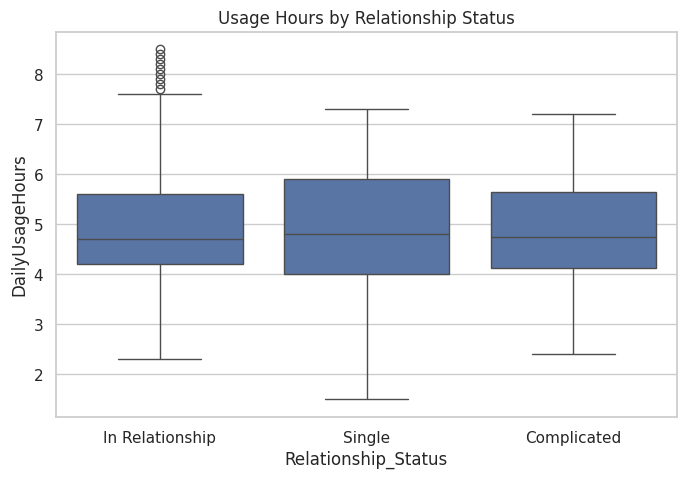

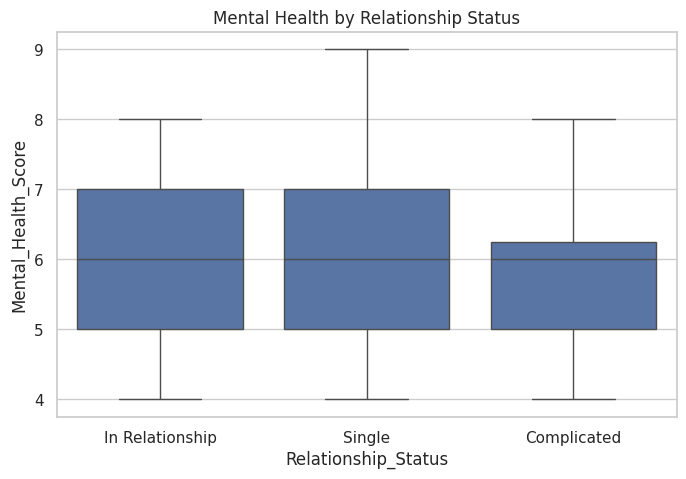

In [14]:
# Daily usage hours impact on relationship
sns.boxplot(x='Relationship_Status', y='DailyUsageHours', data=df)
plt.title('Usage Hours by Relationship Status'); plt.show()

# Mental health score impact on relationship
sns.boxplot(x='Relationship_Status', y='Mental_Health_Score', data=df)
plt.title('Mental Health by Relationship Status'); plt.show()

### There semms to be no lik between relationship status, even the "complicated" ones. Wheter students are single or dating their mental health and daily usage of social media seems about the same

# Step 9: Correlation heatmap

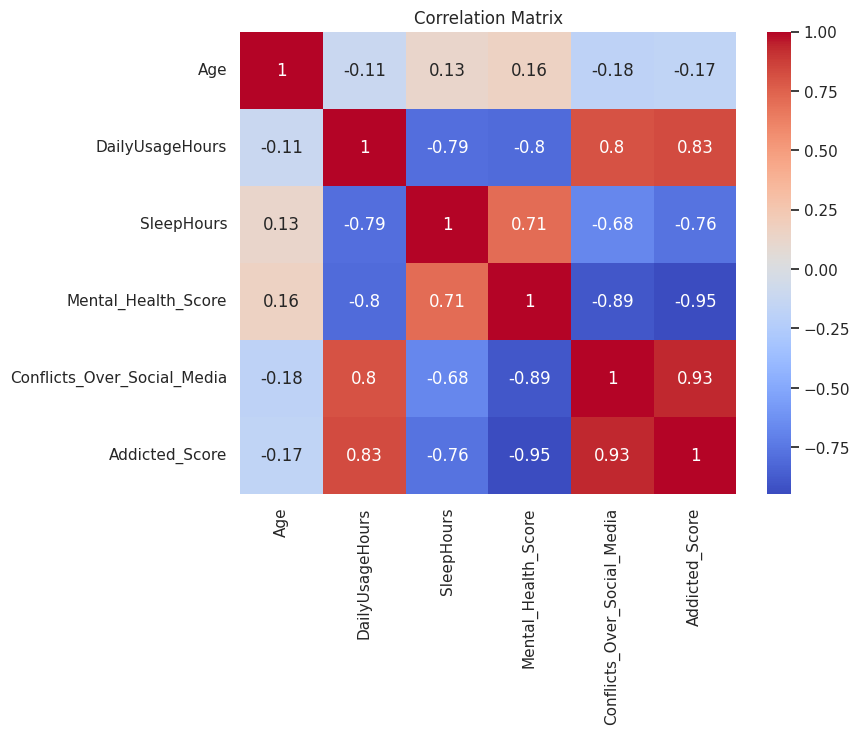

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix'); plt.show()

### Some very strong correlations here indicate multicolinearity on multiple variables. "Addiction Score", "Conflicts over Social Media", "Daily Usage" and "Sleep Hours" are all factores strongly correlated

# Step 10: Prepare features and target variables

### Here we select "Affects Academic Performance" as the target variable to be explained. This is a binary "yes" or "no" variable which says if negative impacts are felt and/or visible in academic assessments

In [16]:
y = df['Affects_Academic_Performance'].map({'Yes': 1, 'No': 0})
X = df.drop(columns=['Affects_Academic_Performance', 'Student_ID'], errors='ignore')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Step 11: Check multicollinearity with VIF

### Variance Inflation Factor will help detect wheter the strong correlations observed will impact future models. An auxiliary function and heatmap are produced to measure and visualize it




VIF scores:
 const                                  3087.345451
Age                                       4.195149
Mental_Health_Score                      11.249380
Conflicts_Over_Social_Media               9.366930
Addicted_Score                           24.131174
SleepHours                                4.534549
DailyUsageHours                           6.664878
Gender_Male                               2.186777
Academic_Level_High School                2.410019
Academic_Level_Undergraduate              5.266710
Most_Used_Platform_Instagram              2.530416
Most_Used_Platform_KakaoTalk              1.204106
Most_Used_Platform_LINE                   1.357356
Most_Used_Platform_LinkedIn               1.680670
Most_Used_Platform_Snapchat               1.290830
Most_Used_Platform_TikTok                 2.480174
Most_Used_Platform_Twitter                1.265357
Most_Used_Platform_VKontakte              1.102288
Most_Used_Platform_WeChat                 1.136417
Most_Used_Platfor

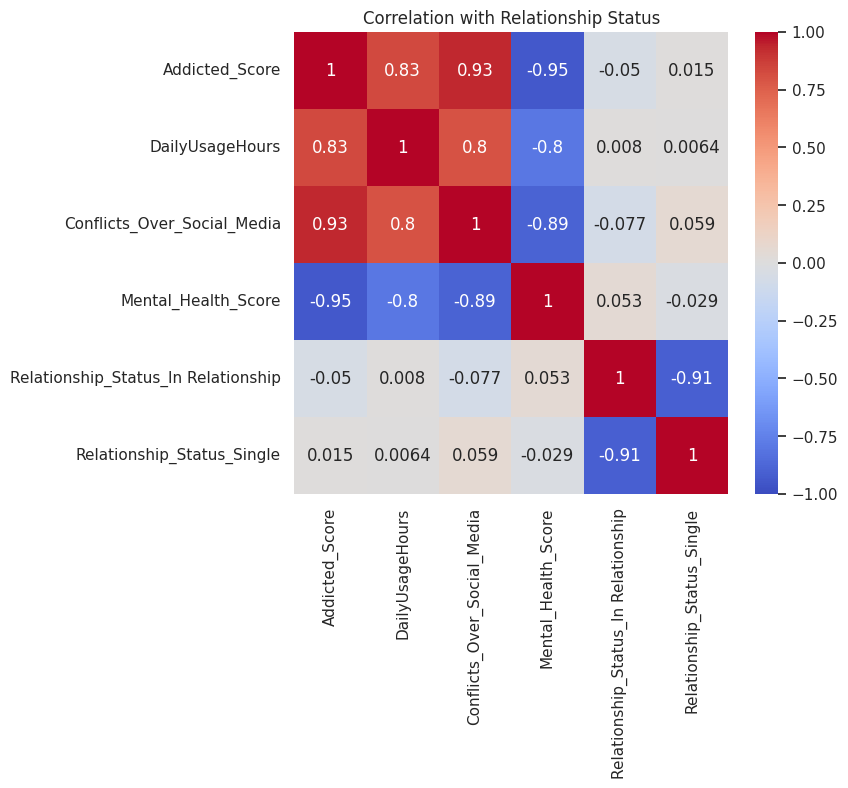

In [17]:
def compute_vif(df_input):
    vif_df = sm.add_constant(df_input)
    return pd.Series(
        [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])],
        index=vif_df.columns,
        name='VIF')

vif_scores = compute_vif(X)
print("\nVIF scores:\n", vif_scores)

# Multicollinearity heatmap for key features
key_feats = ['Addicted_Score', 'DailyUsageHours', 'Conflicts_Over_Social_Media',
             'Mental_Health_Score', 'Relationship_Status_In Relationship',
             'Relationship_Status_Single']
plt.figure(figsize=(7, 6))
sns.heatmap(X[key_feats].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Relationship Status'); plt.show()

### "Addiction Score", "Conflicts over Social Media", "Daily Usage" and "Sleep Hours" possess high VIF scores, as expected. Interestingly the relationship status is also flagged here, probably due to lack of importance of relationship status on "Academic Performance" so both describe the virtually the same variance and can be used interchangeably

# Step 12: Train-test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Step 14: ROC/AUC plotting function

In [21]:
def plot_roc(y_true, y_score, label=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")
    return roc_auc

# Step 15: Baseline (null) and full logistic regression models

### The null model is built with no variables except for the intercept constant. This model will give us the baseline AUC value for fitness enabling comparison of predictive performance of later models. The "full" model comprised every available variable, even the highly correlated ones

In [22]:
# Null logistic model
X0 = sm.add_constant(pd.DataFrame(np.zeros((len(y_train), 0)), index=y_train.index))
model_null = sm.Logit(y_train, X0).fit(disp=False)
print(f"Null Model AIC: {model_null.aic:.2f}")

# Full logistic model
X1 = sm.add_constant(X_train)
model_full = sm.Logit(y_train, X1).fit(disp=False)
print(f"Full Model AIC: {model_full.aic:.2f}")

Null Model AIC: 737.85


LinAlgError: Singular matrix

### This error was expected due to multicolonearity, and was kept here for academic purposes

# Step 16: LASSO Logistic Regression

### LASSO or "Least Absolute Shrinkage and Selection Operator" is a a linear regression technique that uses a regularization method to prevent overfitting and simplify models. It's used to deal with multicolinearity and facilitating feature selection.

In [25]:
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))])

pipeline_lasso.fit(X_train, y_train)
coefs = pd.Series(pipeline_lasso.named_steps['lasso'].coef_[0], index=X_train.columns)
print("\nNon-zero LASSO coefficients:")
print(coefs[coefs.abs() > 1e-6].sort_values(ascending=False))


Non-zero LASSO coefficients:
Conflicts_Over_Social_Media     5.407063
Addicted_Score                  4.042342
Most_Used_Platform_KakaoTalk    0.105981
Relationship_Status_Single      0.061393
Most_Used_Platform_YouTube     -0.079405
dtype: float64


### THe LASSO logistic regression sucessfully fitted the model and determined the coeficients. "Conflicts over Social Media" and "Addiction Score" dominate the model with only minority coefficients remaining. THe LASSO determined the these two variables alone are the best possible explanation to "Affects Academic Performance"

# Step 17: Compare ROC curves

### Does the LASSO model improve the null one?

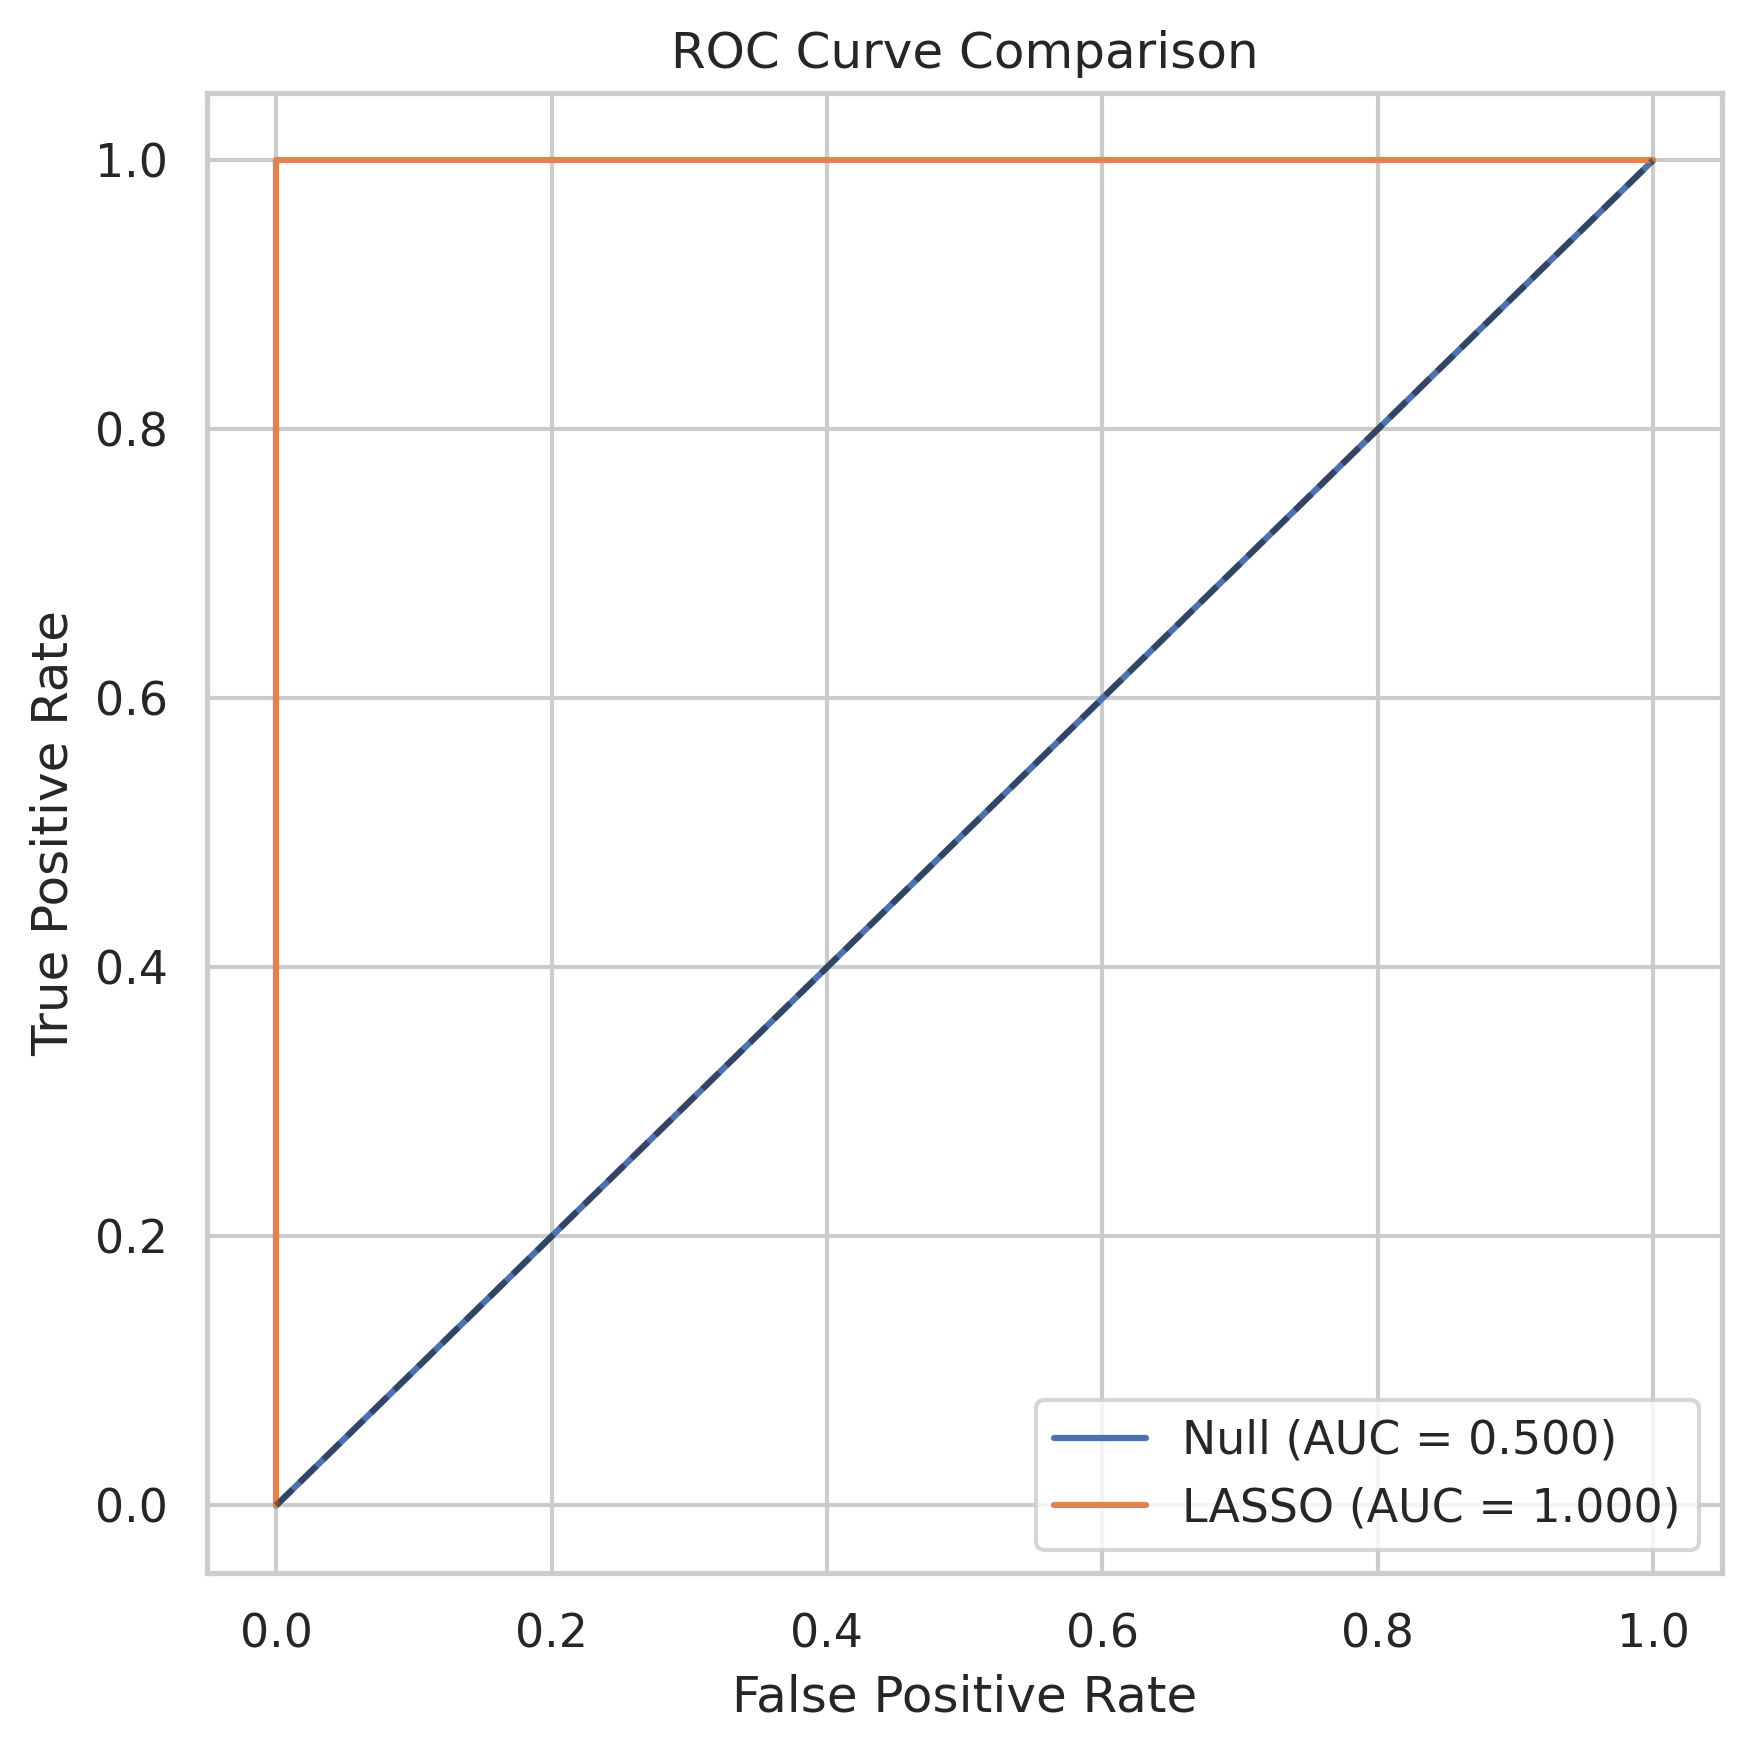

In [27]:
plt.figure(figsize=(6, 6), dpi=300)

# Null
y_null_score = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
auc_null = plot_roc(y_test, y_null_score, label='Null')

# LASSO
y_lasso_score = pipeline_lasso.predict_proba(X_test)[:, 1]
auc_lasso = plot_roc(y_test, y_lasso_score, label='LASSO')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# Step 18: Confusion matrices and classification reports

In [28]:
print("Confusion Matrix & Report: LASSO")
y_pred = (y_lasso_score >= 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

Confusion Matrix & Report: LASSO
[[50  0]
 [ 0 91]]
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        50
         Yes       1.00      1.00      1.00        91

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



### Results indicate overfit on the LASSO model. A 100% true positive rate and 0% false positive rate is at first glance great, but might indicate some problems. Same variables might be direcly derived from others and be an exact predictor of "Impact Academic Performance"

# Step 19: Cross-validated AUC for LASSO

### Cross-validation might indicate wheter the result is accurate or not increasing robustness

In [31]:
cv_auc = cross_val_score(pipeline_lasso, X, y, cv=15, scoring='roc_auc')
print(f"Cross-validated AUC (5-fold): {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

Cross-validated AUC (5-fold): 1.000 ± 0.000


# Step 20: Alternative LASSO variants via cross-validation

### Considering the perfect predictor score of our model the next step is identify variables too closely related to our target. This version of the model will remove the 2 variables selected from the original LASSO model and fit it again via cross-validation. This new model is known as "No Both" model.

In [34]:
def evaluate_variants(X_base, y, variants_dict, cv=15):
    results = {}
    for name, X_var in variants_dict.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))])
        scores = cross_val_score(pipeline, X_var, y, cv=cv, scoring='roc_auc')
        results[name] = scores
        print(f"{name} — AUC per fold: {np.round(scores,3)}")
        print(f"{name} — Mean AUC = {scores.mean():.3f} ± {scores.std():.3f}\n")
    return results

variants = {
    'No Addicted_Score': X.drop(columns=['Addicted_Score']),
    'No Conflicts': X.drop(columns=['Conflicts_Over_Social_Media']),
    'No Both': X.drop(columns=['Addicted_Score','Conflicts_Over_Social_Media'])}

evaluate_variants(X, y, variants)

No Addicted_Score — AUC per fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
No Addicted_Score — Mean AUC = 1.000 ± 0.000

No Conflicts — AUC per fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
No Conflicts — Mean AUC = 1.000 ± 0.000

No Both — AUC per fold: [0.992 1.    1.    1.    1.    1.    1.    1.    1.    1.    0.988 0.949
 1.    1.    1.   ]
No Both — Mean AUC = 0.995 ± 0.013



{'No Addicted_Score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'No Conflicts': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'No Both': array([0.99193548, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.98823529, 0.94901961, 1.        , 1.        , 1.        ])}

# Step 21: Alternative LASSO "No Both" predictions and ROC

Variables retained in 'No Both' model:
Most_Used_Platform_TikTok              1.300683
Most_Used_Platform_Instagram           0.940456
Relationship_Status_Single             0.672646
DailyUsageHours                        0.417508
Most_Used_Platform_Snapchat            0.175853
Most_Used_Platform_KakaoTalk           0.134125
Gender_Male                            0.101996
Most_Used_Platform_Twitter             0.055057
Relationship_Status_In Relationship   -0.268211
Most_Used_Platform_VKontakte          -0.284931
Age                                   -0.823745
Academic_Level_Undergraduate          -1.000364
Academic_Level_High School            -1.111288
Mental_Health_Score                   -6.642701
dtype: float64


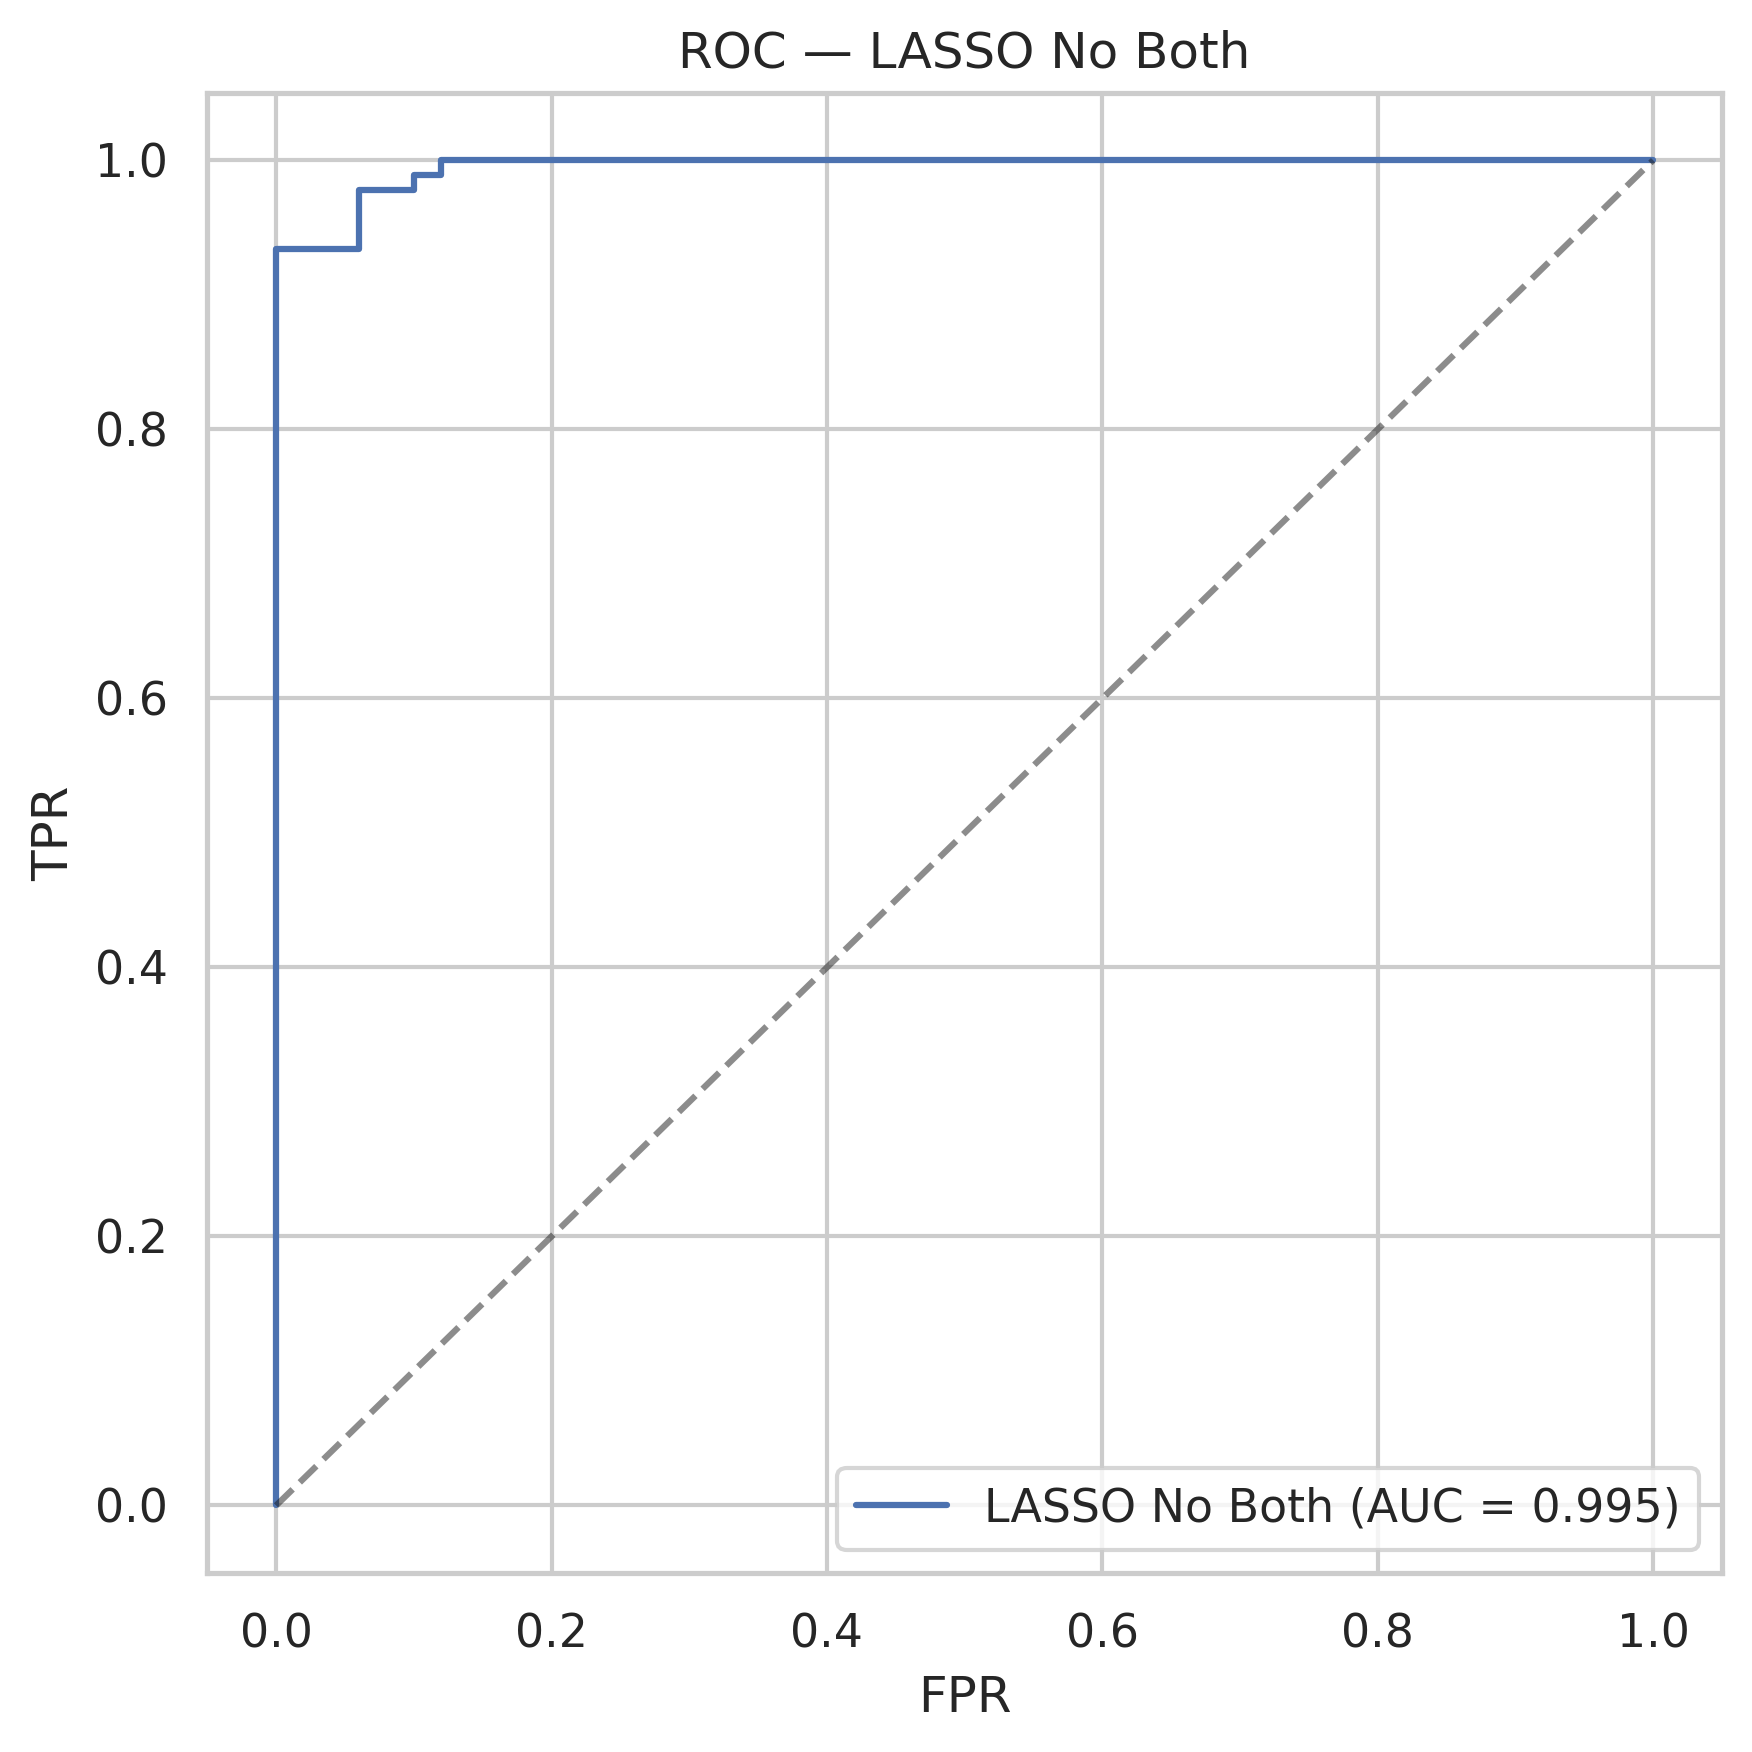

Confusion and report — LASSO No Both
[[47  3]
 [ 3 88]]
              precision    recall  f1-score   support

          No       0.94      0.94      0.94        50
         Yes       0.97      0.97      0.97        91

    accuracy                           0.96       141
   macro avg       0.95      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141



In [35]:
# Romove the variables from X
X_nb = variants['No Both']
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_nb, y, test_size=0.2, random_state=42, stratify=y)

# re-writing the pipeline to fit de model
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))])
pipeline_nb.fit(X_train_nb, y_train_nb)
coefs_nb = pd.Series(pipeline_nb.named_steps['lasso'].coef_[0], index=X_train_nb.columns)
print("Variables retained in 'No Both' model:")
print(coefs_nb[coefs_nb.abs()>1e-6].sort_values(ascending=False))

# Ploting ROC
y_score_nb = pipeline_nb.predict_proba(X_test_nb)[:,1]
plt.figure(figsize=(6,6), dpi=300)
plot_roc(y_test_nb, y_score_nb, label='LASSO No Both')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — LASSO No Both'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# Prediction, confusion matrix and classification report
print("Confusion and report — LASSO No Both")
y_pred_nb = (y_score_nb>=0.5).astype(int)
print(confusion_matrix(y_test_nb, y_pred_nb))
print(classification_report(y_test_nb, y_pred_nb, target_names=['No','Yes']))

### Current model "No Both" definetely took a hit to predictory power, but still posses an AUC score of almost 1.

# Step 22: LASSO only demographic variables

### Final iteration of the logistic model will focus only on demographic variables. These features are less prone to subjective scoring compared to emotinal scores such as "addiction acore" which might mean different things to different people. THis iteration of the model is labelled "Only Demographics"

Demographics-only AUC (15-fold): 0.972 ± 0.029


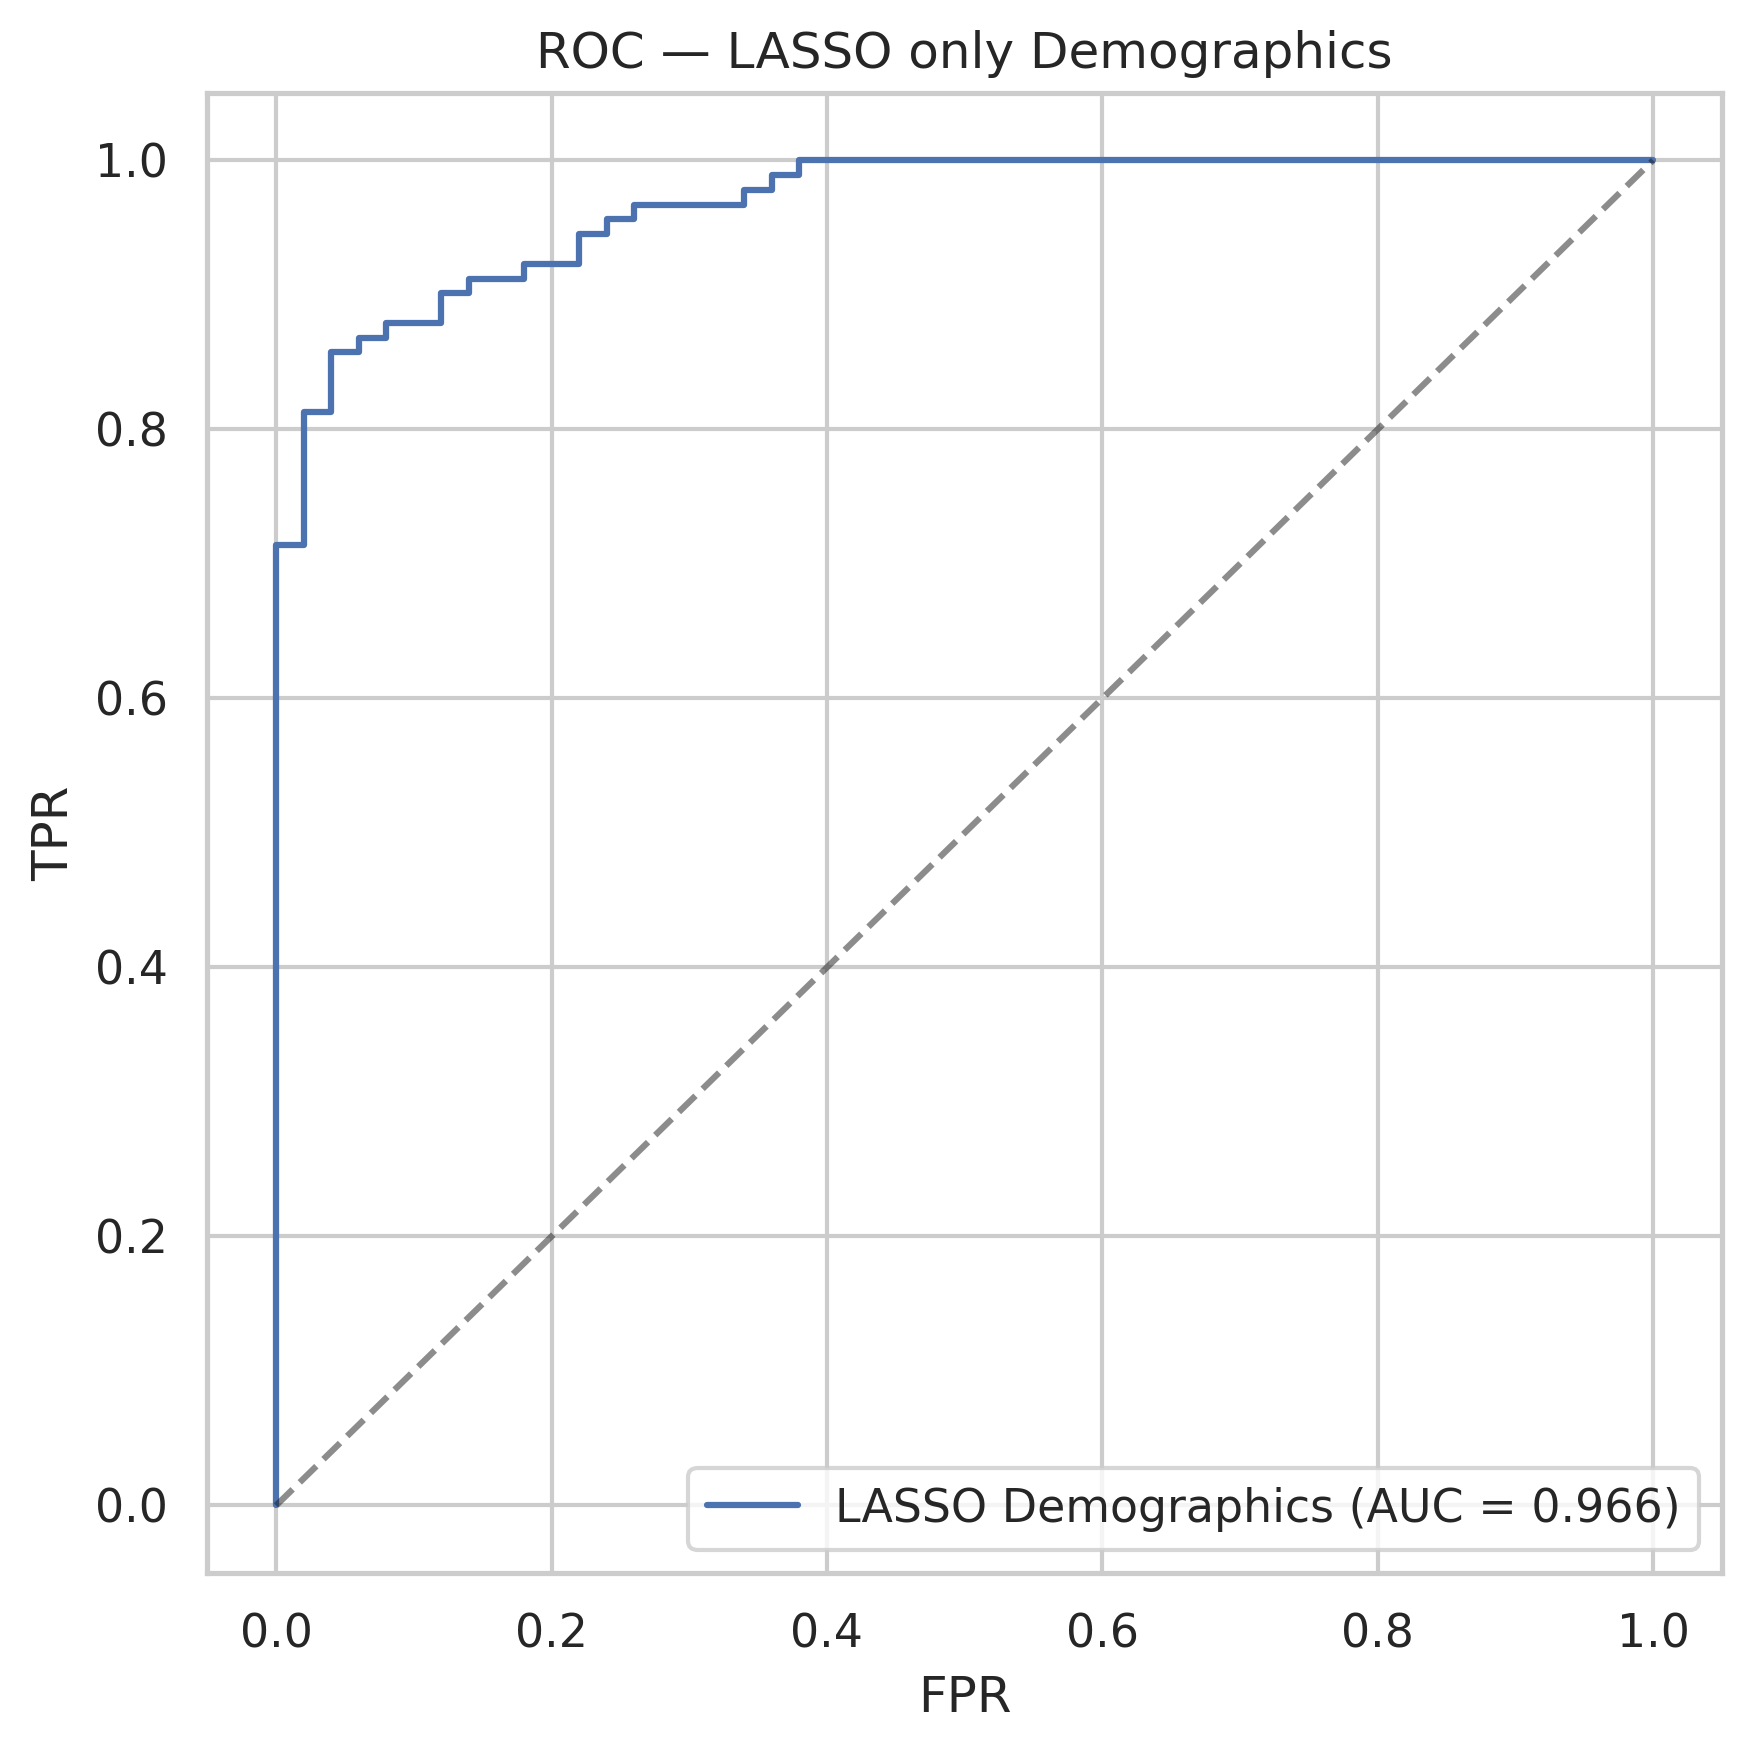

Non-zero coefs — Demographics-only
DailyUsageHours                        2.384791
Most_Used_Platform_TikTok              1.571498
Most_Used_Platform_Instagram           1.071005
Most_Used_Platform_KakaoTalk           0.756484
Most_Used_Platform_Snapchat            0.524909
Most_Used_Platform_WhatsApp            0.291293
Gender_Male                            0.241611
Most_Used_Platform_WeChat              0.142960
Relationship_Status_Single             0.099784
Most_Used_Platform_Twitter             0.053119
Most_Used_Platform_LINE               -0.072910
Most_Used_Platform_LinkedIn           -0.137586
Most_Used_Platform_VKontakte          -0.449256
Relationship_Status_In Relationship   -0.780882
Academic_Level_High School            -0.883375
Age                                   -0.909663
Academic_Level_Undergraduate          -1.235723
SleepHours                            -1.507265
dtype: float64
Confusion and report — LASSO only Demographics
[[44  6]
 [10 81]]
              precis

In [37]:
# Remove selected variables from X
X_clean = X.drop(columns=['Addicted_Score','Conflicts_Over_Social_Media','Mental_Health_Score'])
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=y)

# re-writing the pipeline to fit de model
pipe_clean = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))])
cv_auc_clean = cross_val_score(pipe_clean, X_clean, y, cv=15, scoring='roc_auc')
print(f"Demographics-only AUC (15-fold): {cv_auc_clean.mean():.3f} ± {cv_auc_clean.std():.3f}")

pipe_clean.fit(X_train_clean, y_train_clean)
y_score_clean = pipe_clean.predict_proba(X_test_clean)[:, 1]

# Ploting ROC
plt.figure(figsize=(6,6), dpi=300)
plot_roc(train_test_split(X_clean, y, test_size=0.2, random_state=42, stratify=y)[3], y_score_clean, label='LASSO Demographics')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — LASSO only Demographics'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

print("Non-zero coefs — Demographics-only")
coefs_clean = pd.Series(pipe_clean.named_steps['lasso'].coef_[0], index=X_clean.columns)
print(coefs_clean[coefs_clean.abs()>1e-6].sort_values(ascending=False))

# Prediction, confusion matrix and classification report
print("Confusion and report — LASSO only Demographics")
y_pred_clean = (y_score_clean>=0.5).astype(int)
print(confusion_matrix(y_test_clean, y_pred_clean))
print(classification_report(y_test_clean, y_pred_clean, target_names=['No','Yes']))

### Here we obtain a robusst model which accurately prodicts wheter the academic performance of students is impacted by social media by tangible variables only. Platform of preference, daily usage and number of hours slept are the main drivers of this academic impact

# Step 23: Random Forest Evaluation Function

### Next up is adapting the logistic model success to a RandomForest model. Will a "more complex" ensamble model achieve higher success than a simple regression? Here we follow the same pipeline as before with 3 models fitted: the "full" model with all variables, the "no both" model which excluded the features with highest predictor power, and finally the "only demographics" model

In [38]:
def evaluate_rf(name, X_tr, y_tr, X_te, y_te):
    print(f"{name} - Random Forest Evaluation")
    # Initialize and train model
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_tr, y_tr)
    # Predict probabilities
    y_score = rf.predict_proba(X_te)[:, 1]

    # ROC Curve and AUC
    plt.figure(figsize=(6, 6), dpi=300)
    roc_auc = plot_roc(y_te, y_score, label=name)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name} (AUC = {roc_auc:.3f})')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Confusion Matrix and Classification Report
    y_pred = (y_score >= 0.5).astype(int)
    print("Confusion Matrix:")
    print(confusion_matrix(y_te, y_pred))
    print(classification_report(y_te, y_pred, target_names=['No', 'Yes']))

    # Feature Importances
    importances = pd.Series(rf.feature_importances_, index=X_tr.columns)
    importances = importances.sort_values(ascending=False)
    plt.figure(figsize=(8, 6), dpi=300)
    importances.head(10).plot(kind='bar')
    plt.title(f'Top 10 Feature Importances - {name}')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Step 24: Execute Random Forest for each dataset variant

RF Full - Random Forest Evaluation


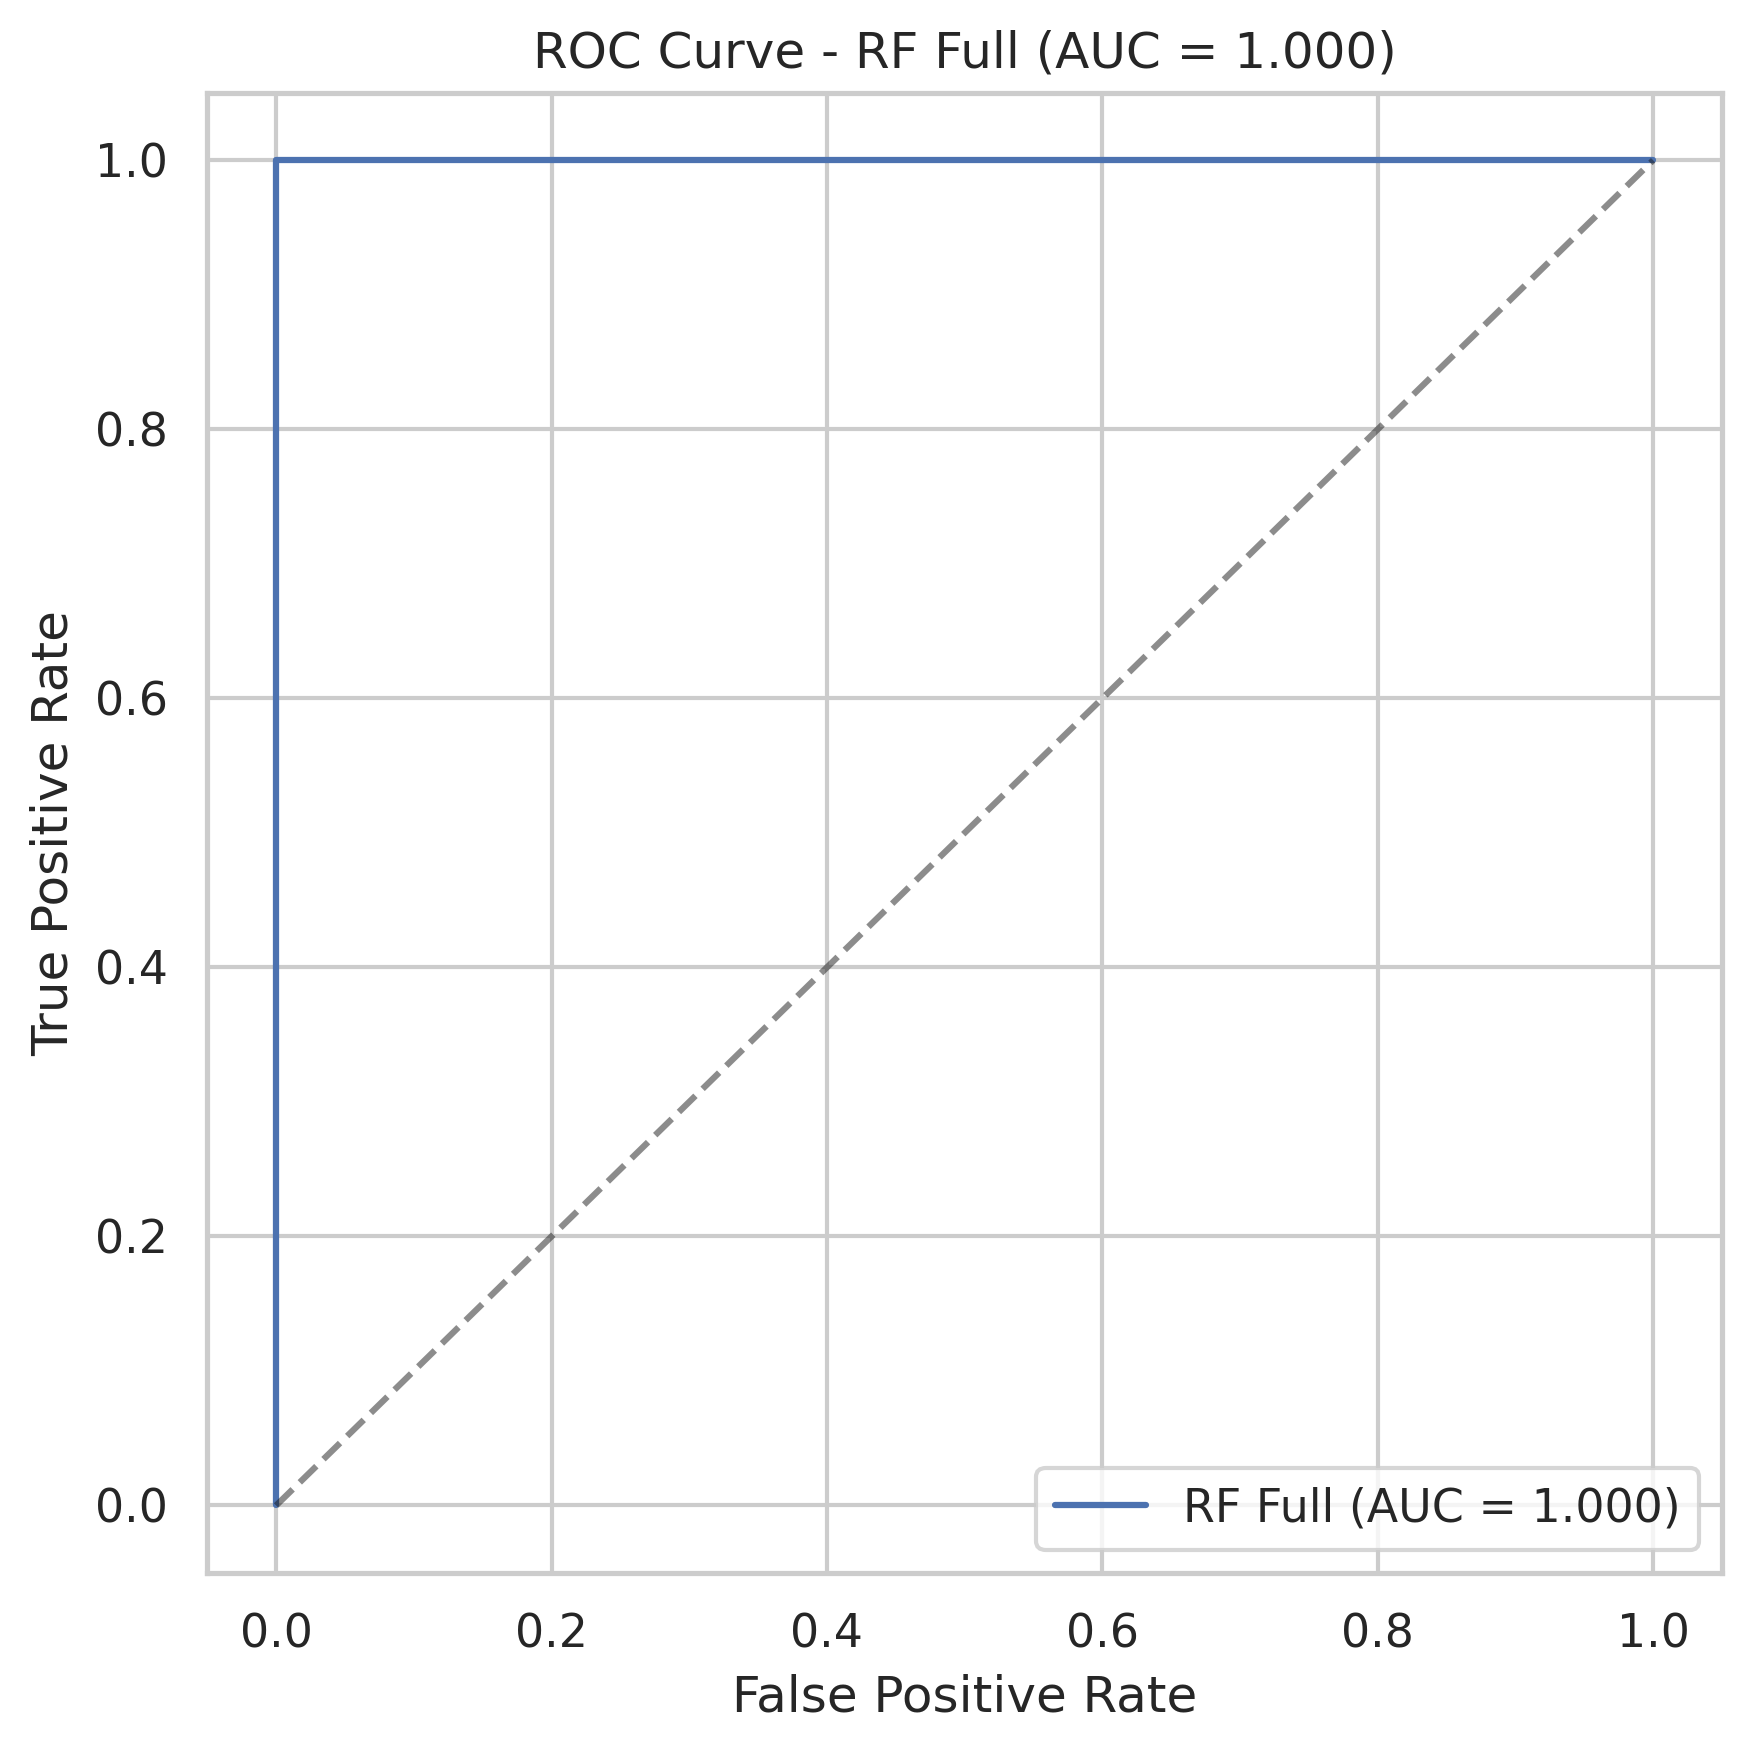

Confusion Matrix:
[[50  0]
 [ 0 91]]
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        50
         Yes       1.00      1.00      1.00        91

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



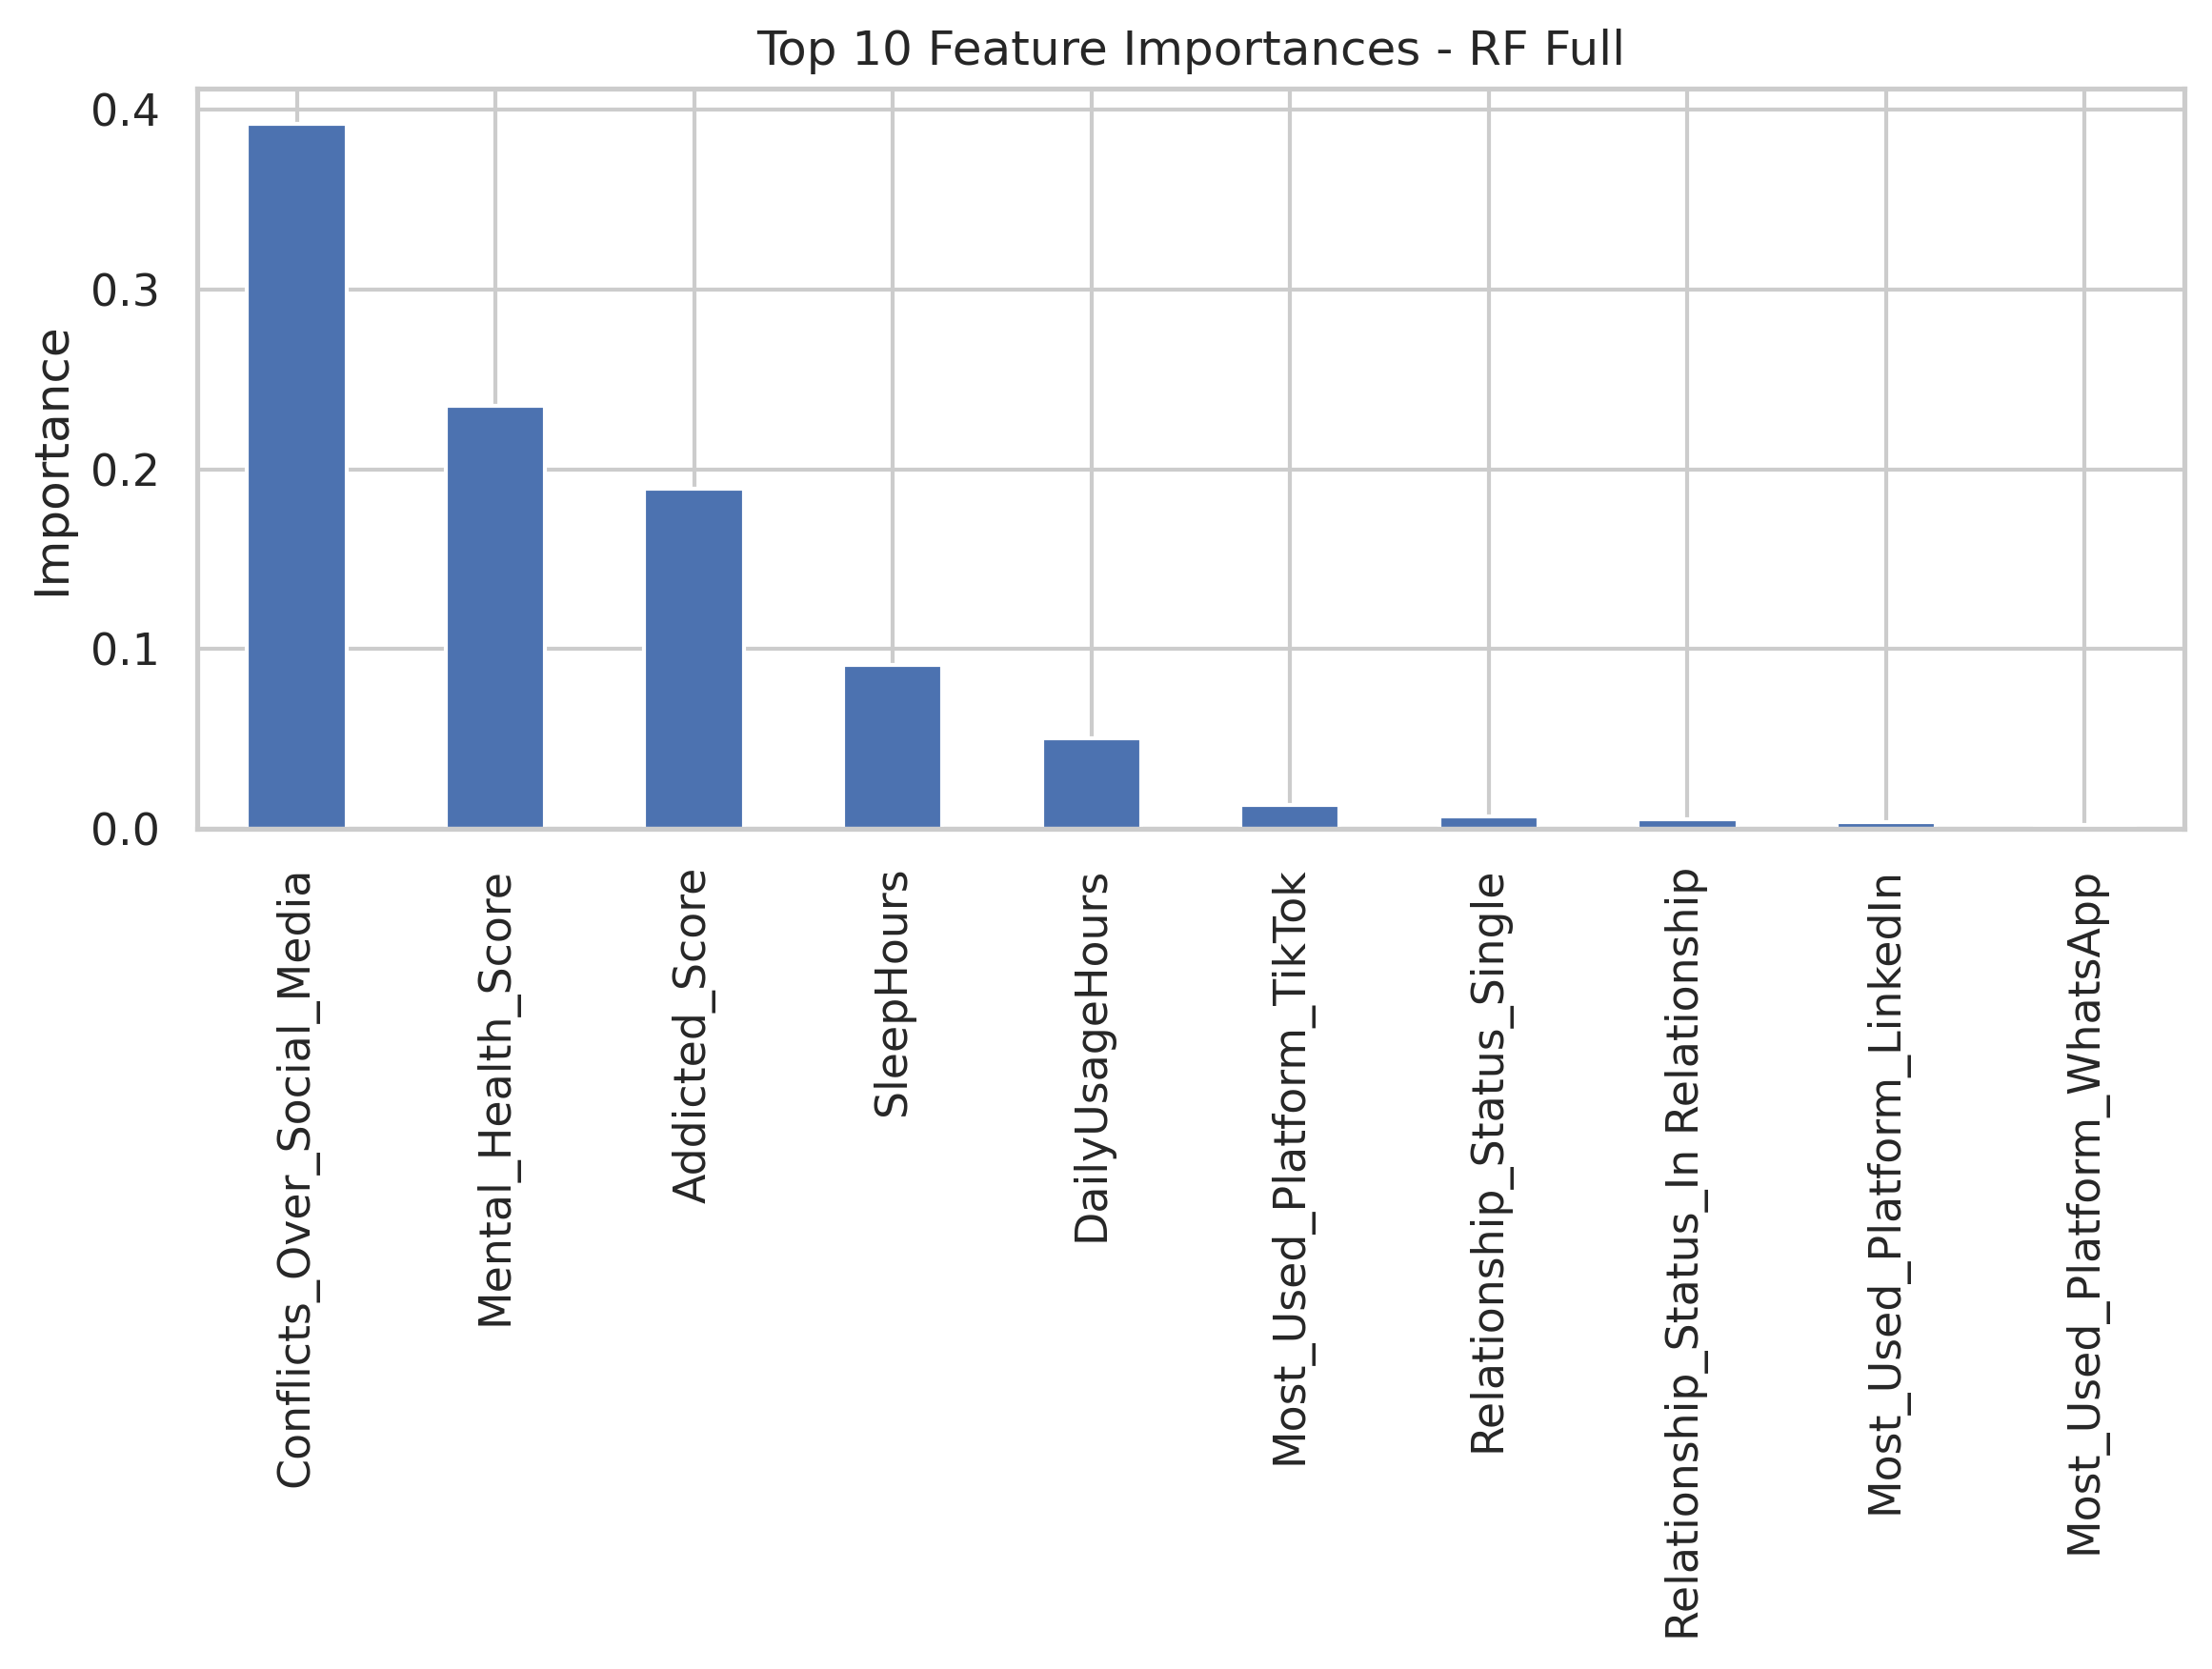

RF No Both - Random Forest Evaluation


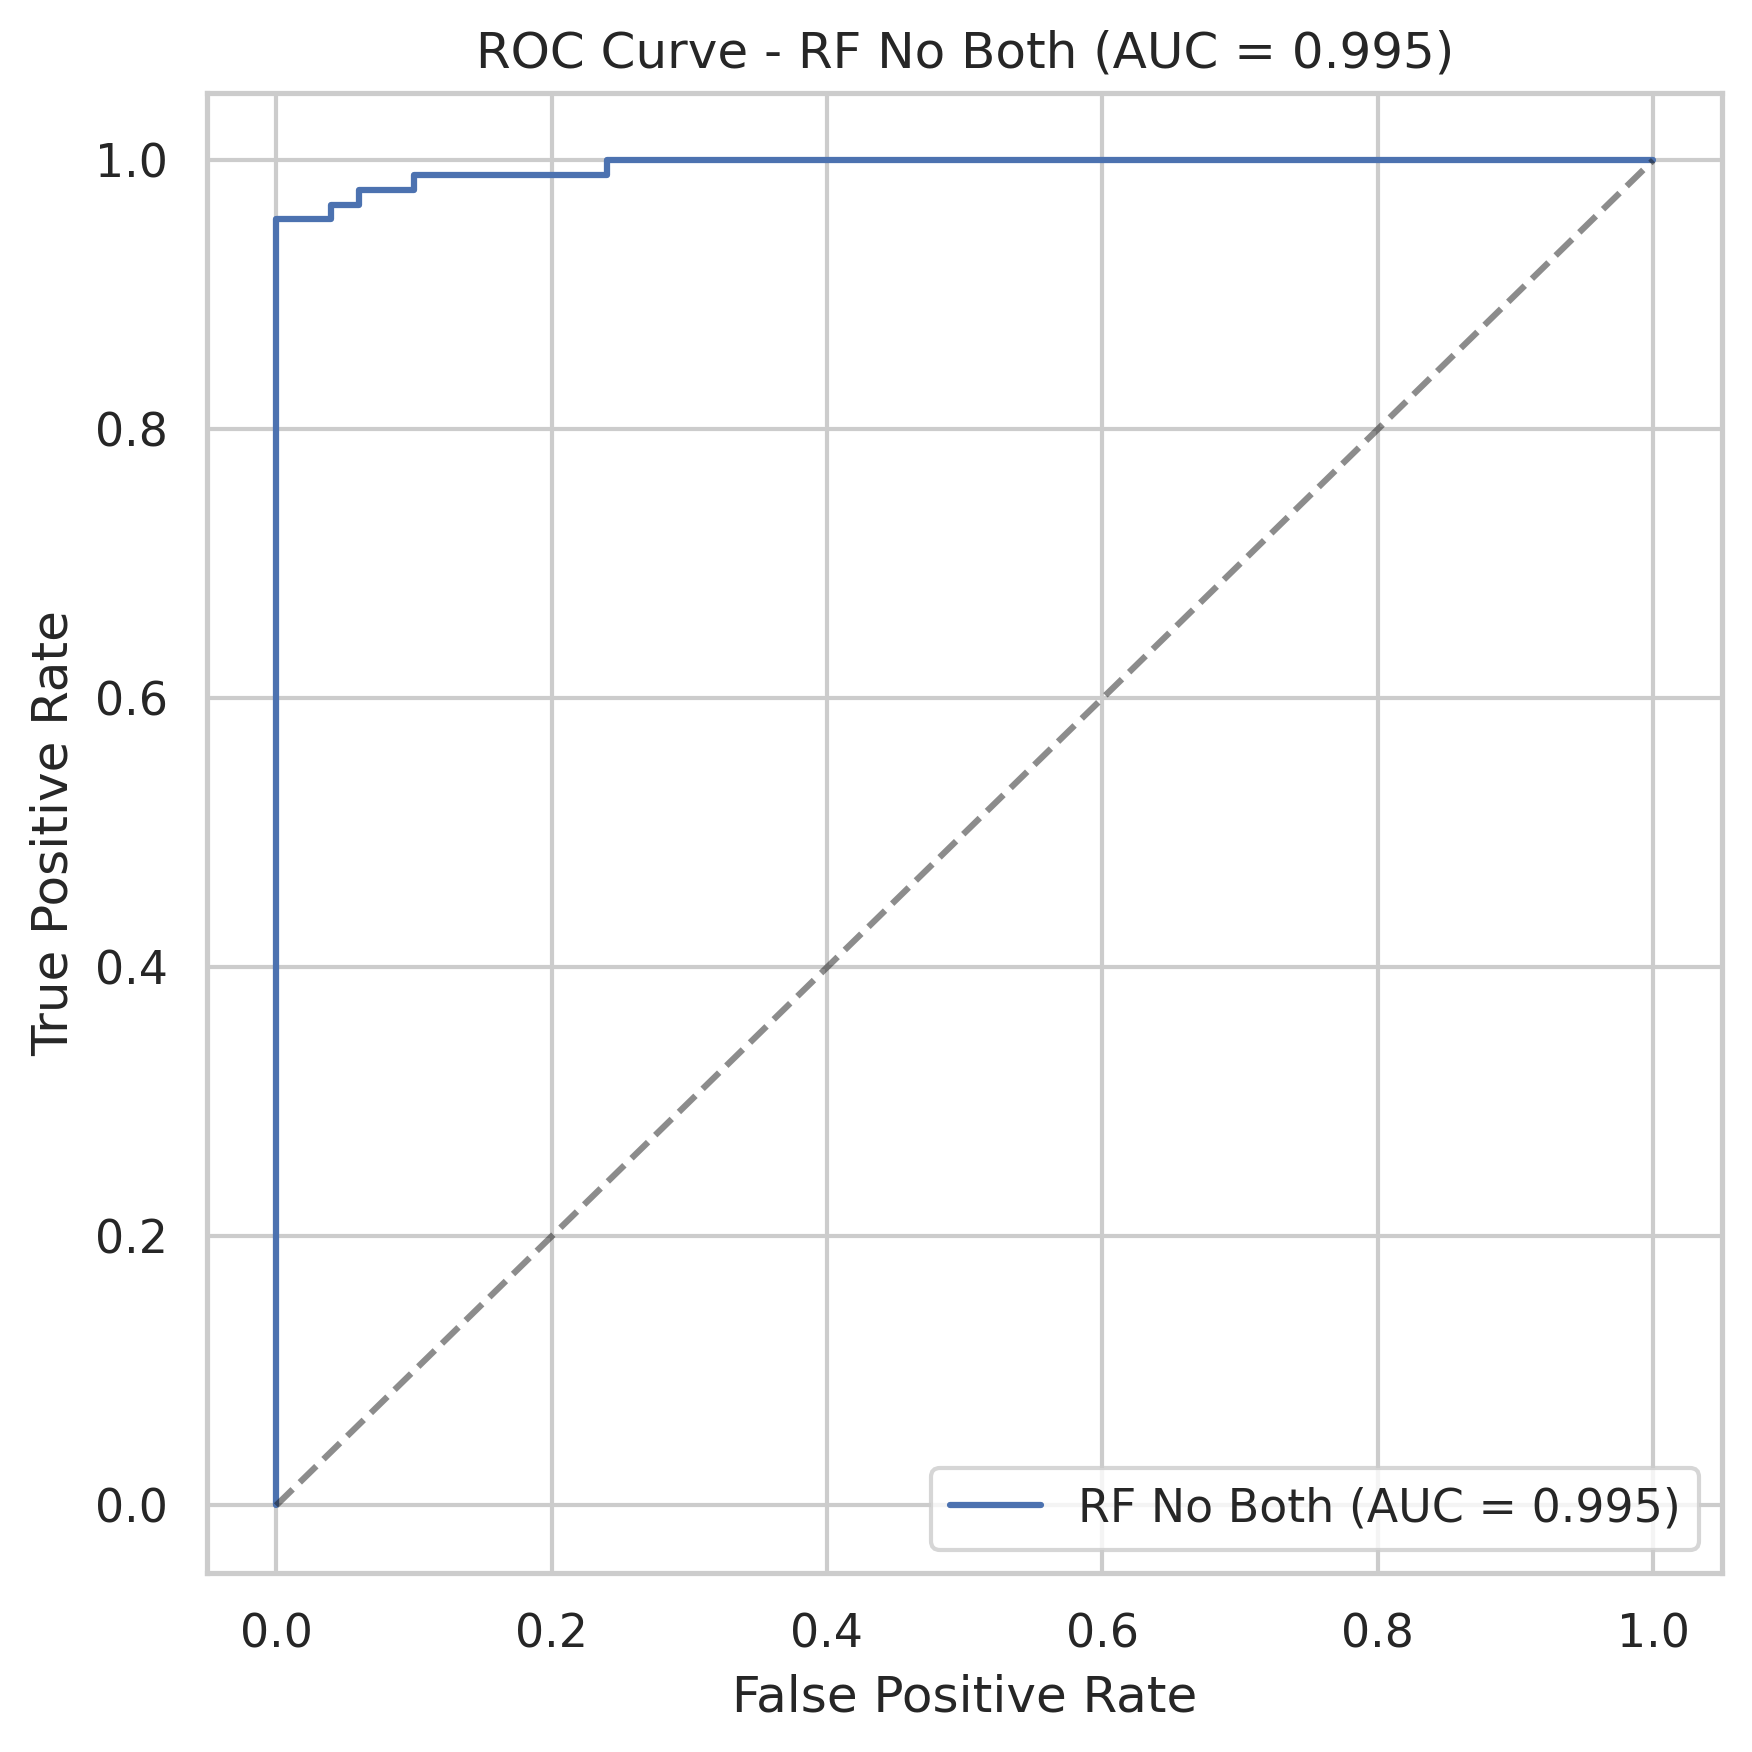

Confusion Matrix:
[[46  4]
 [ 2 89]]
              precision    recall  f1-score   support

          No       0.96      0.92      0.94        50
         Yes       0.96      0.98      0.97        91

    accuracy                           0.96       141
   macro avg       0.96      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141



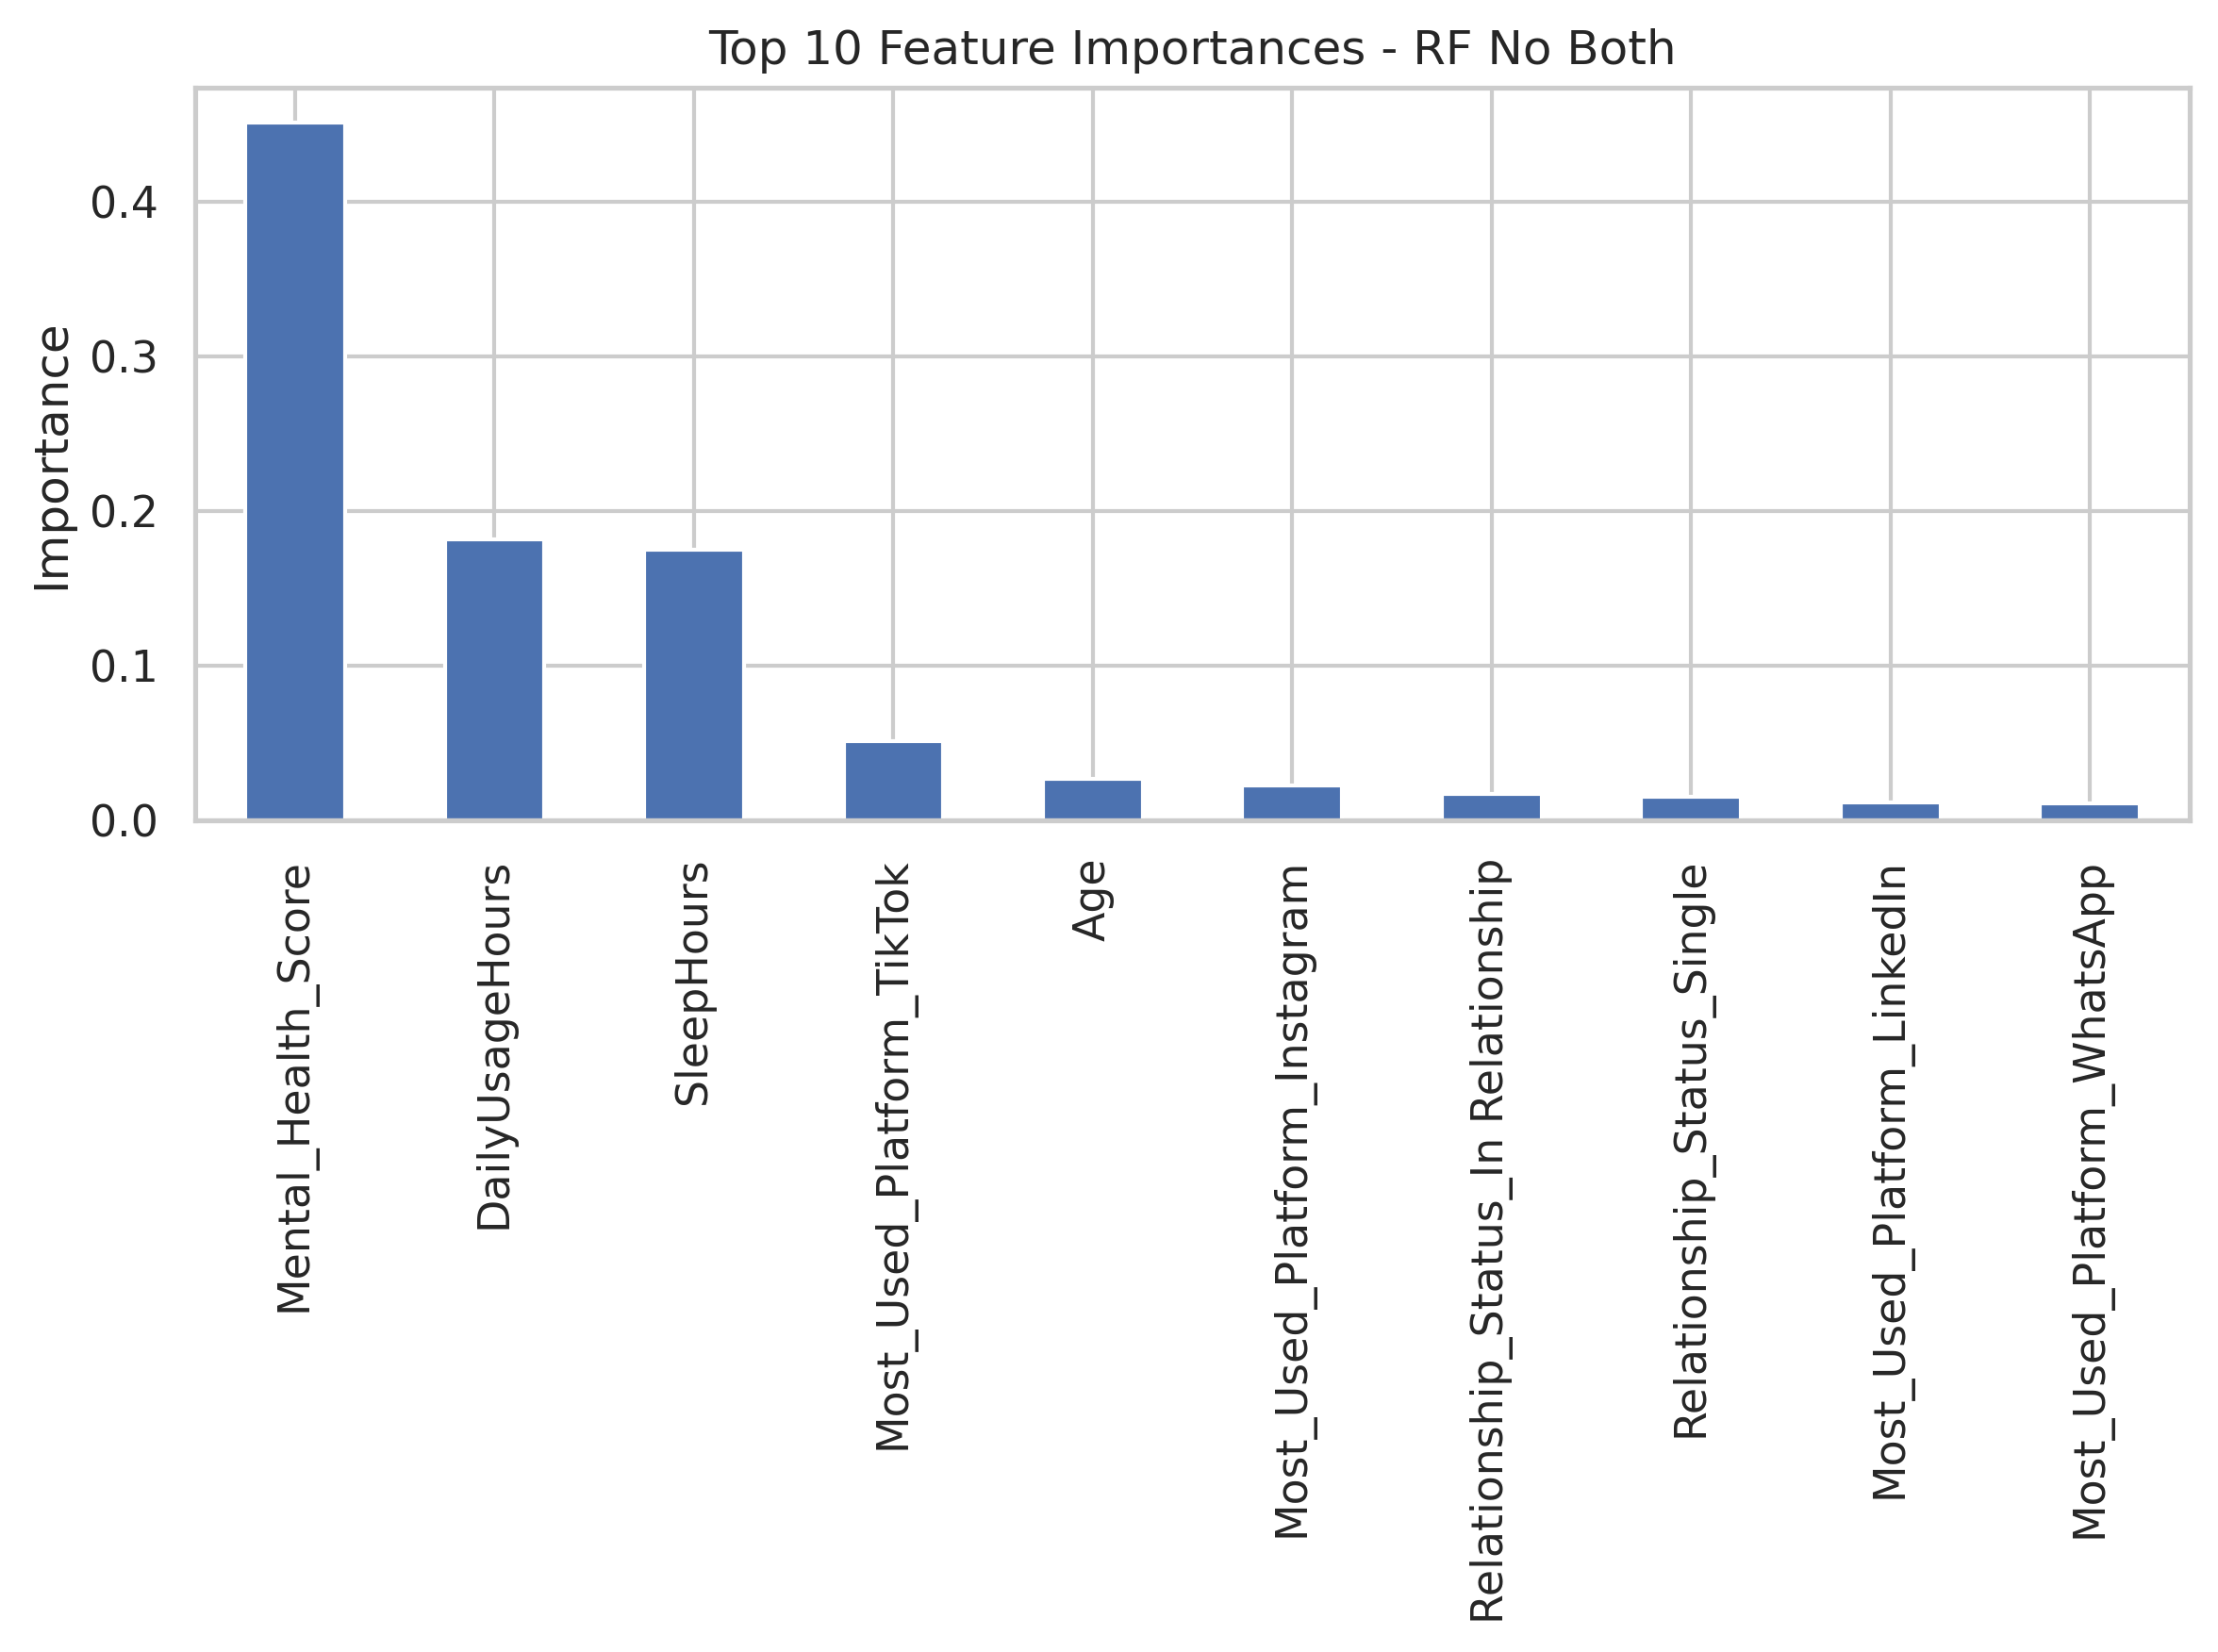

RF Demographics Only - Random Forest Evaluation


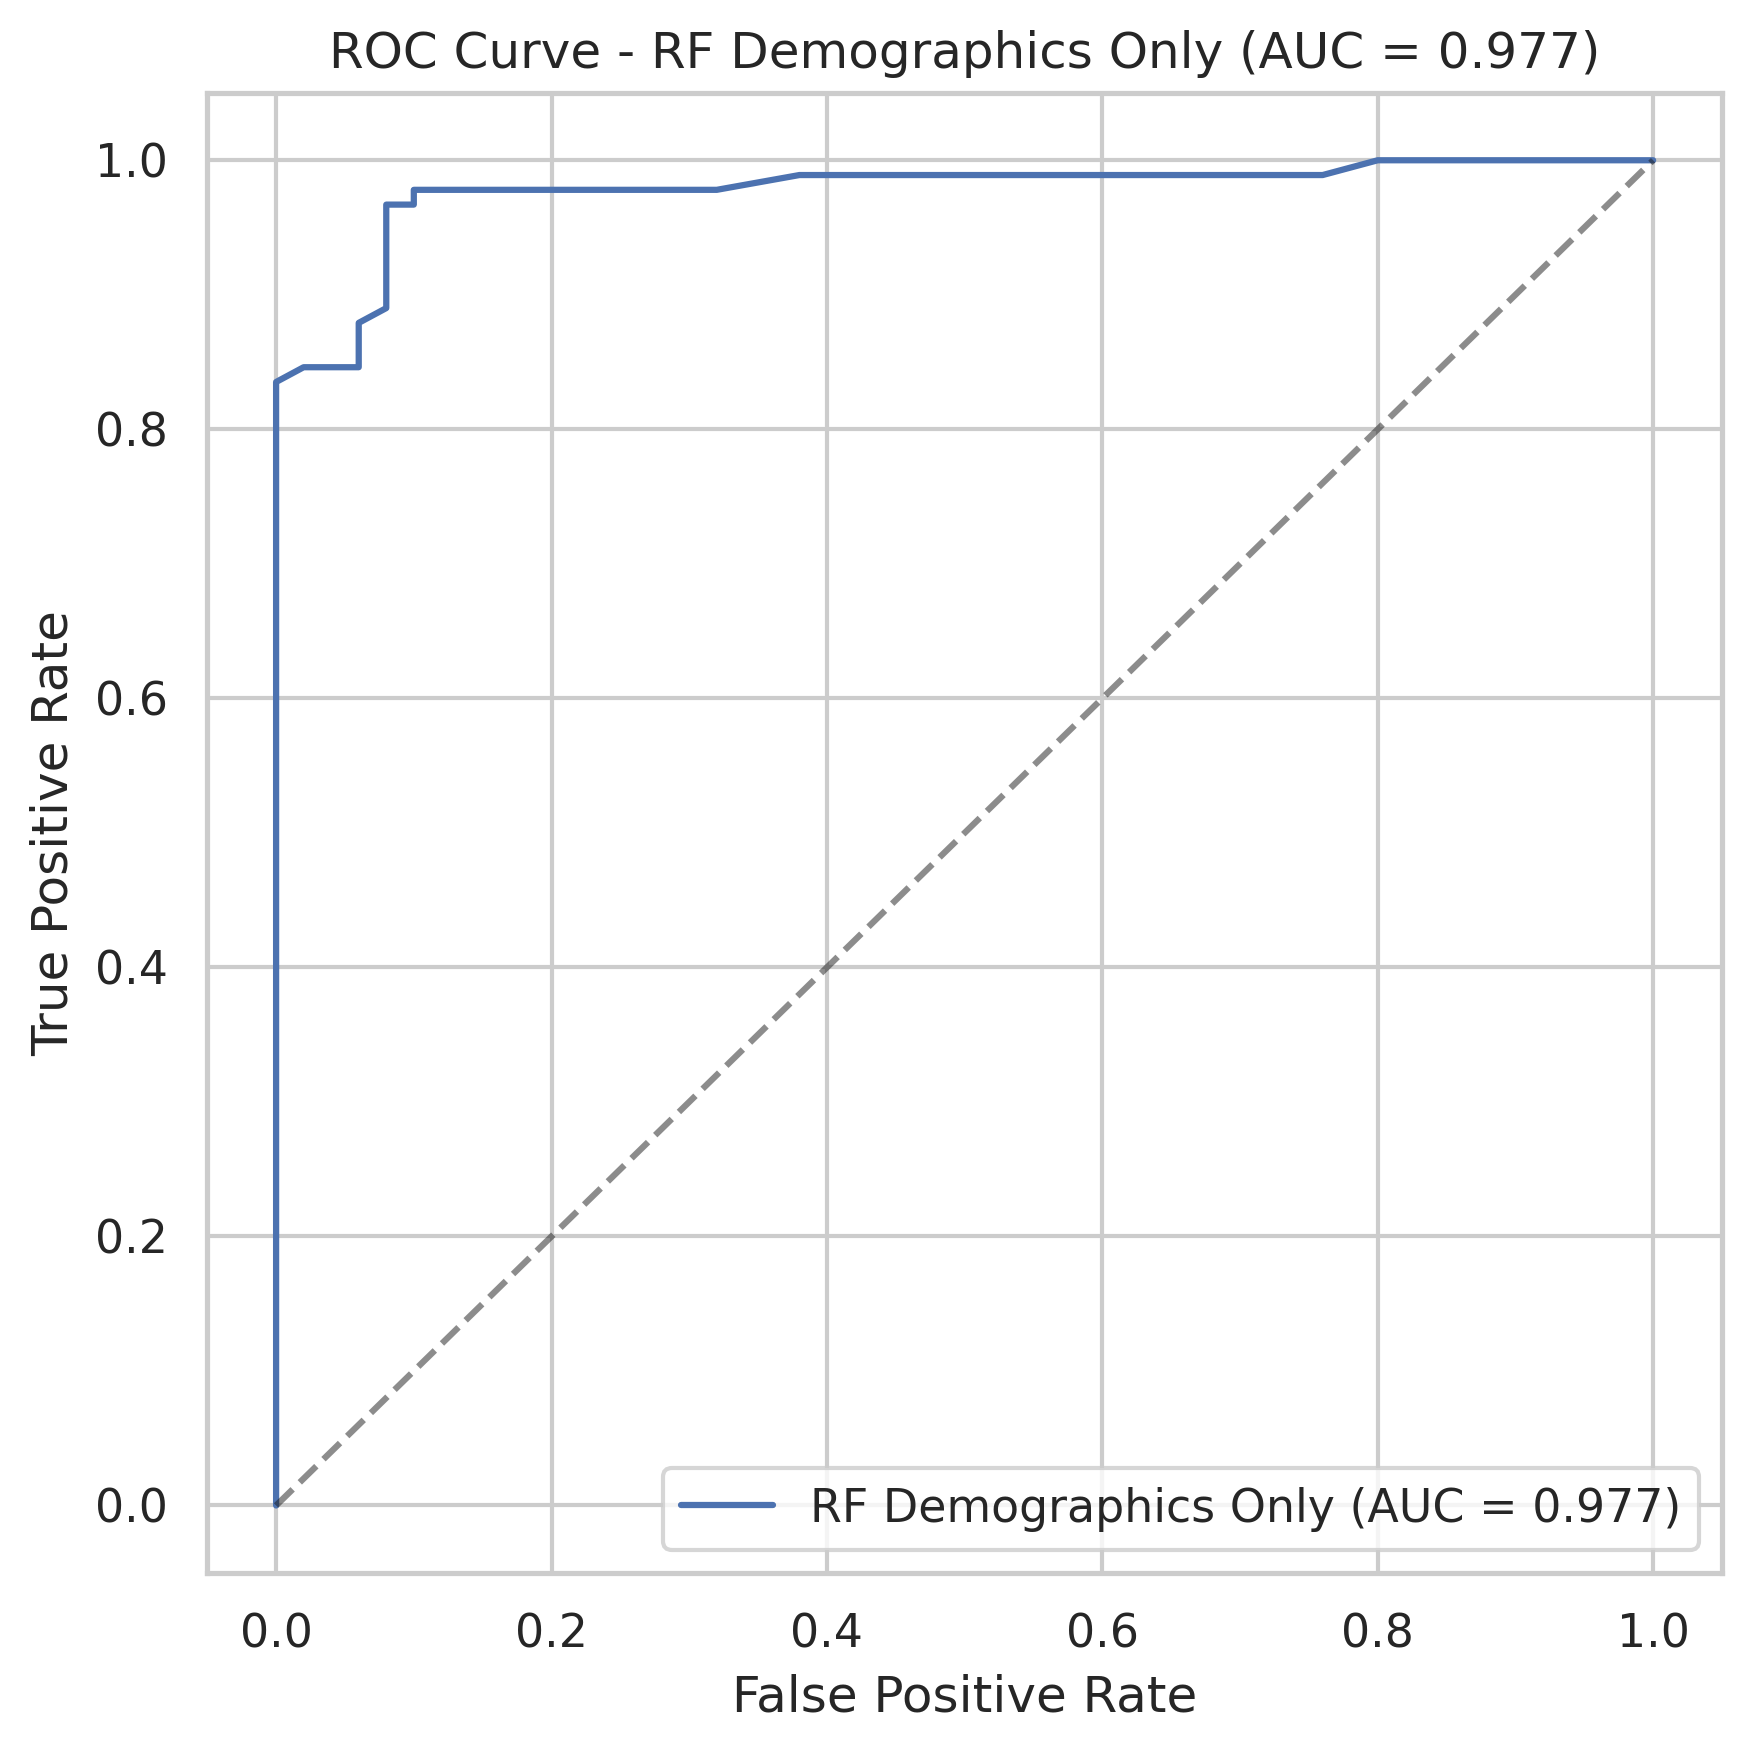

Confusion Matrix:
[[45  5]
 [ 2 89]]
              precision    recall  f1-score   support

          No       0.96      0.90      0.93        50
         Yes       0.95      0.98      0.96        91

    accuracy                           0.95       141
   macro avg       0.95      0.94      0.94       141
weighted avg       0.95      0.95      0.95       141



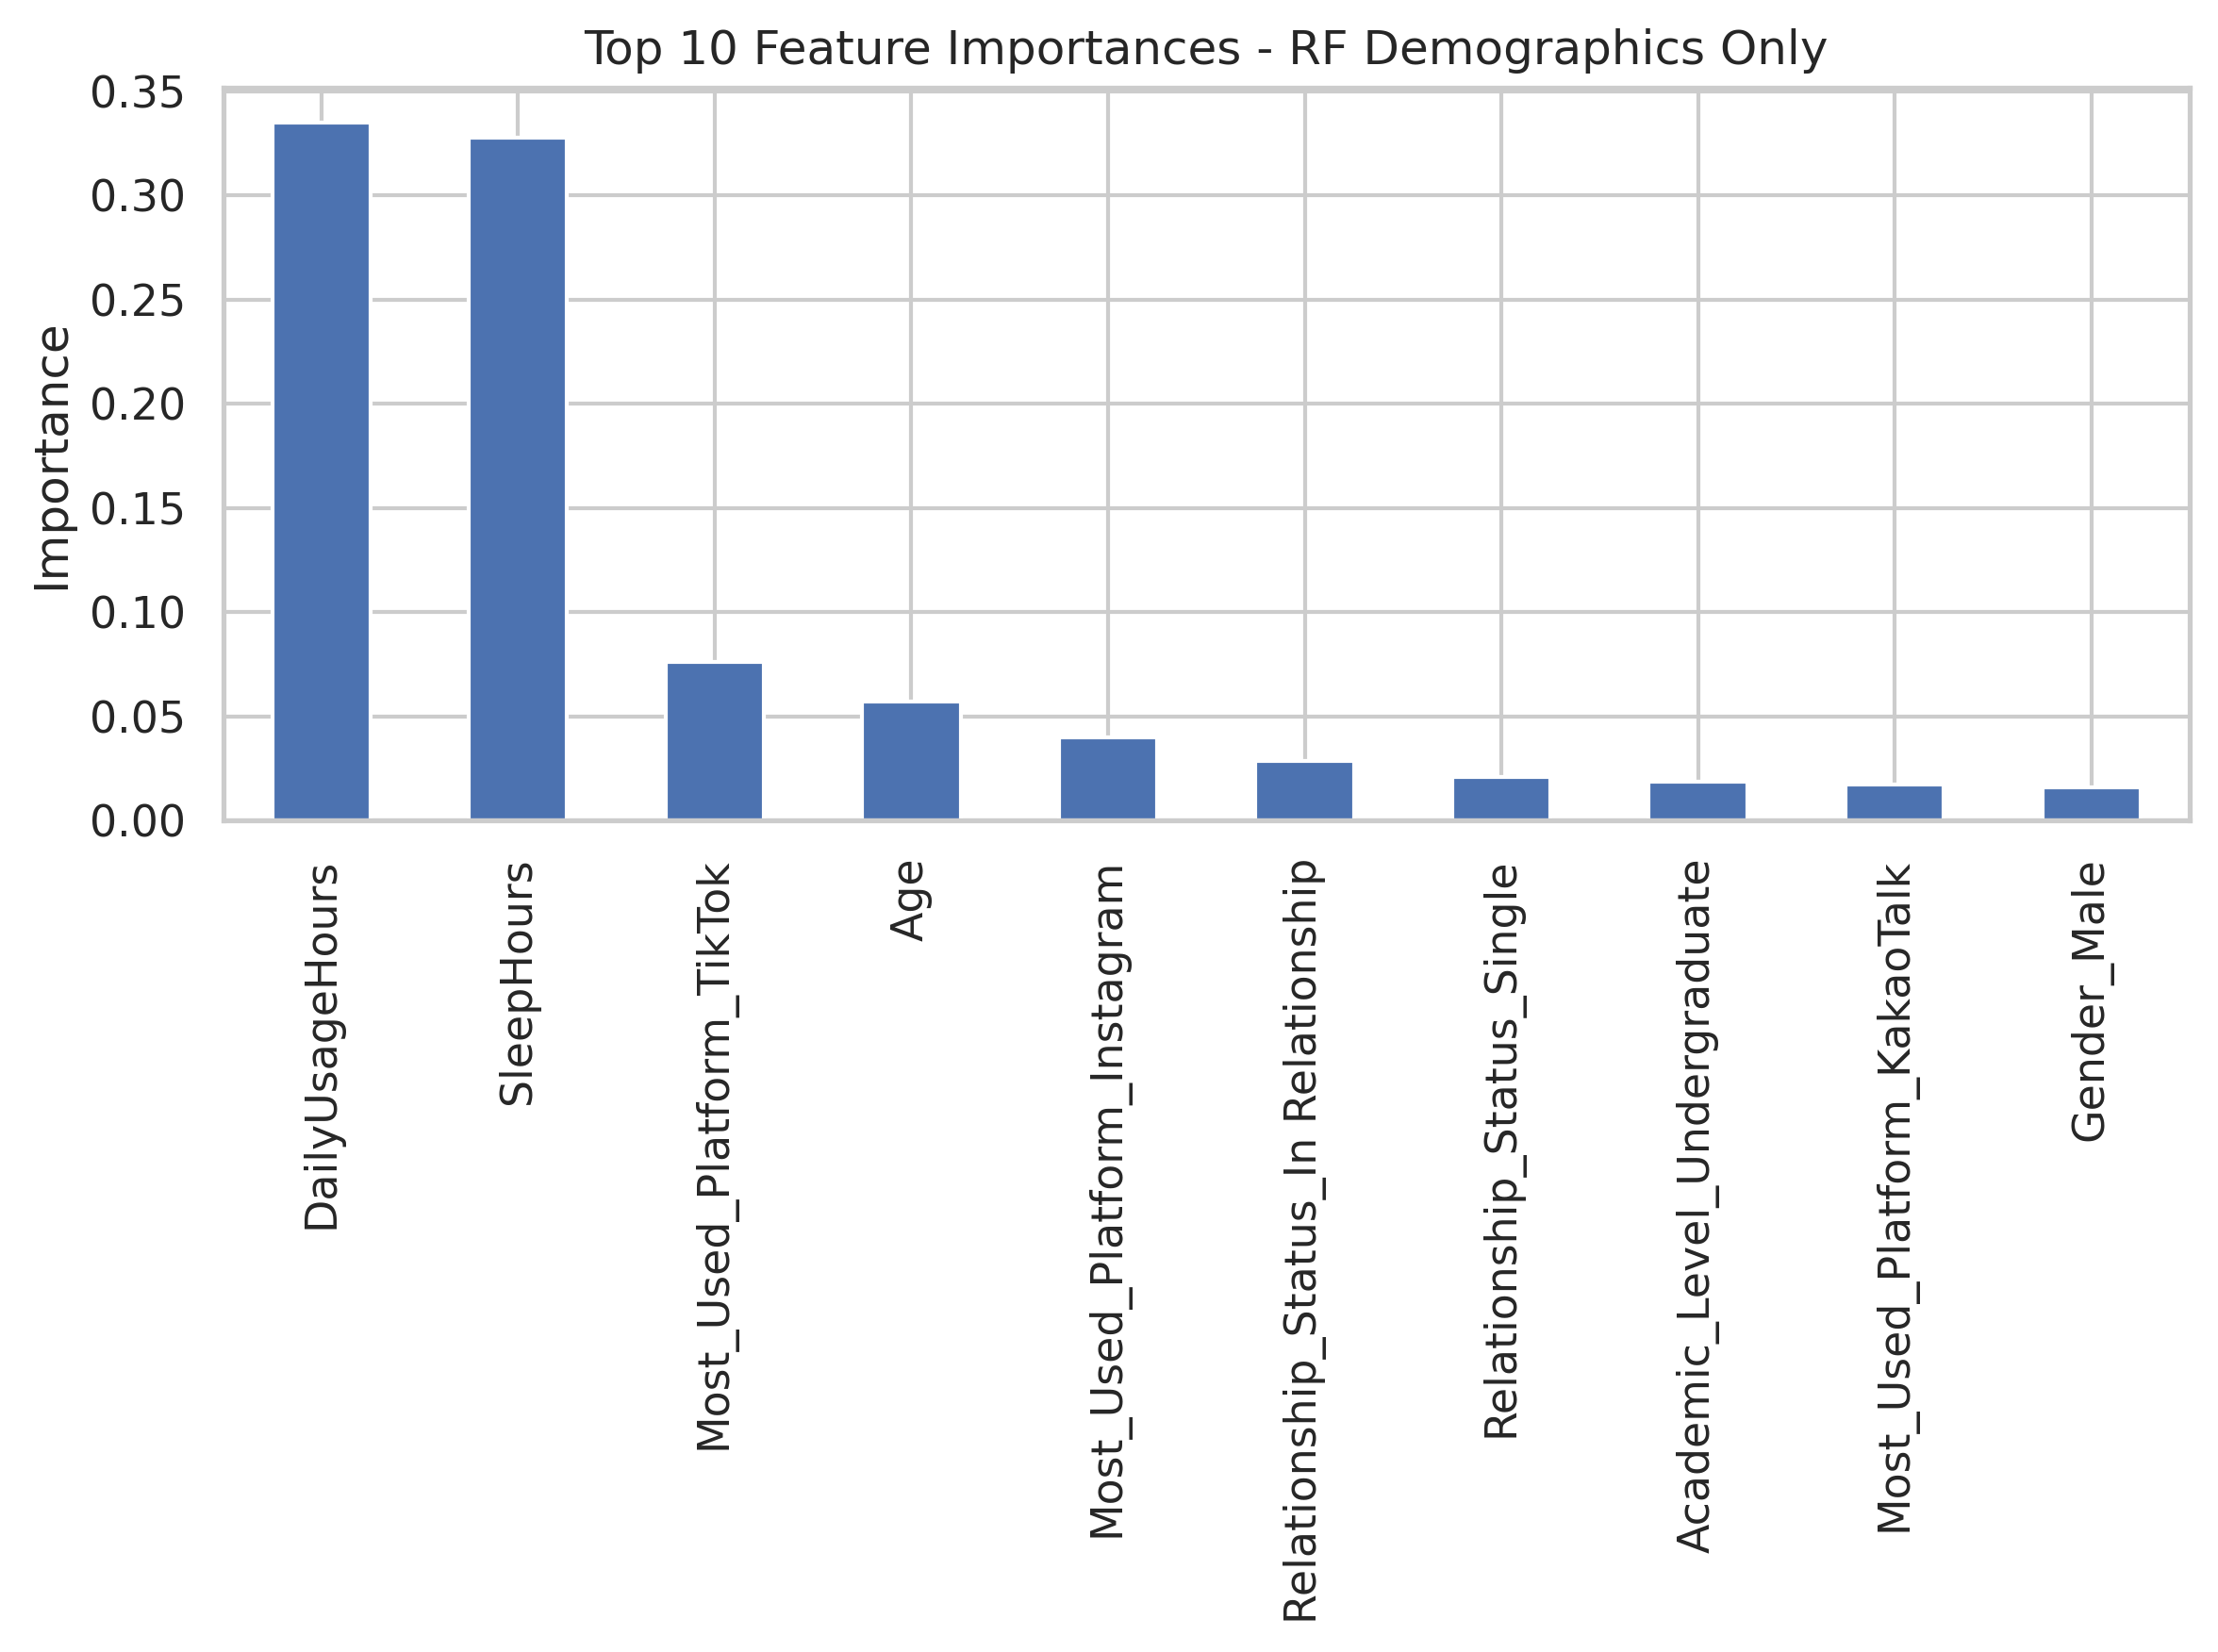

In [39]:
evaluate_rf("RF Full", X_train, y_train, X_test, y_test)
evaluate_rf("RF No Both", X_train_nb, y_train_nb, X_test_nb, y_test_nb)
evaluate_rf("RF Demographics Only", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

### The results here are comparable to the logistic function: "Full" model with perfect accuracy, "no both" model with slightly worse performance and "demographics only" model with the worst but still excelent performance

### The feature importance analysis determined "Conflicts" and "Mental Health" as the strongest predictors in the "full model. "Mental Health", "Daily Usage" and "hours Slept" as the main predictors for "No Both". Finally "Daily Usage" and "Hours Slept" for the "Demographics Only" RandomForest model

### In the end this ensamble model achieved similar prediction scores compared to the logistic regression, and determined the exact same 2 variables as the most important one for the target variable prediction

# Step 26: XGBoost Evaluation Function

# Por fim vamos repetir o processo do RandomForest com XGBoost como ensamble model escolhido. Mesmo três configurações de modelos vão ser criadas

In [41]:
def evaluate_xgb(name, X_tr, y_tr, X_te, y_te):
    print(f"{name} - XGBoost Evaluation")
    # Initialize and train model
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_tr, y_tr)
    # Predict probabilities
    y_score = xgb.predict_proba(X_te)[:, 1]

    # ROC Curve and AUC
    plt.figure(figsize=(6, 6), dpi=300)
    roc_auc = plot_roc(y_te, y_score, label=name)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name} (AUC = {roc_auc:.3f})')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Confusion Matrix and Classification Report
    y_pred = (y_score >= 0.5).astype(int)
    print("Confusion Matrix:")
    print(confusion_matrix(y_te, y_pred))
    print(classification_report(y_te, y_pred, target_names=['No', 'Yes']))

    # Feature Importances
    importances = pd.Series(xgb.feature_importances_, index=X_tr.columns)
    importances = importances.sort_values(ascending=False)
    plt.figure(figsize=(8, 6), dpi=300)
    importances.head(10).plot(kind='bar')
    plt.title(f'Top 10 Feature Importances - {name}')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

XGB Full - XGBoost Evaluation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:57:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


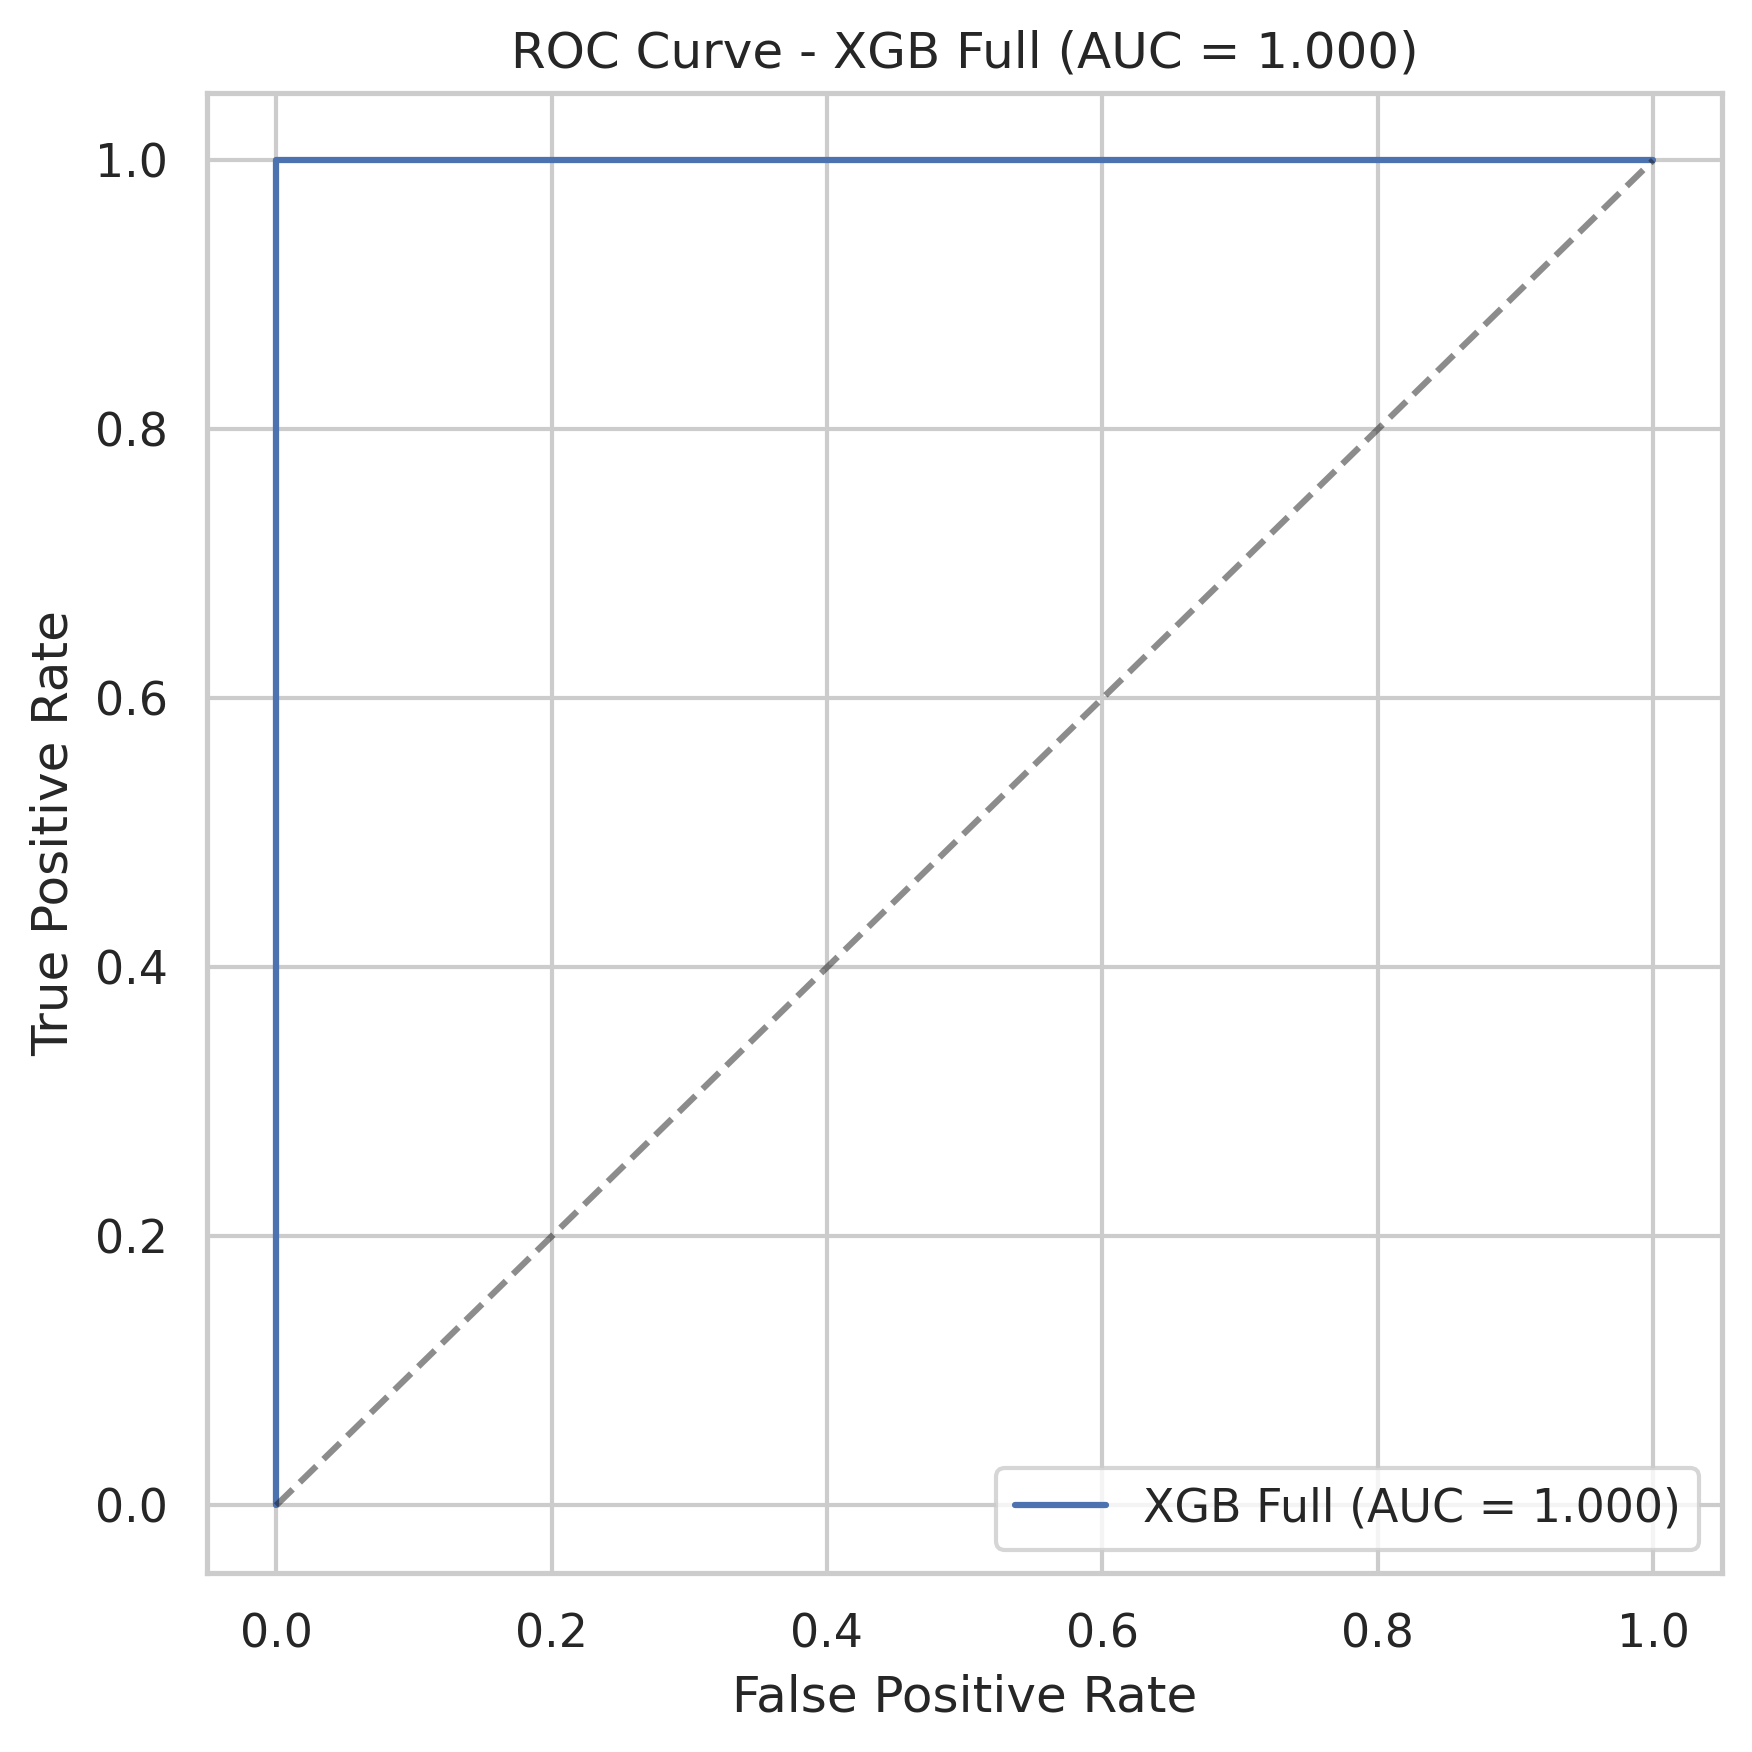

Confusion Matrix:
[[50  0]
 [ 0 91]]
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        50
         Yes       1.00      1.00      1.00        91

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



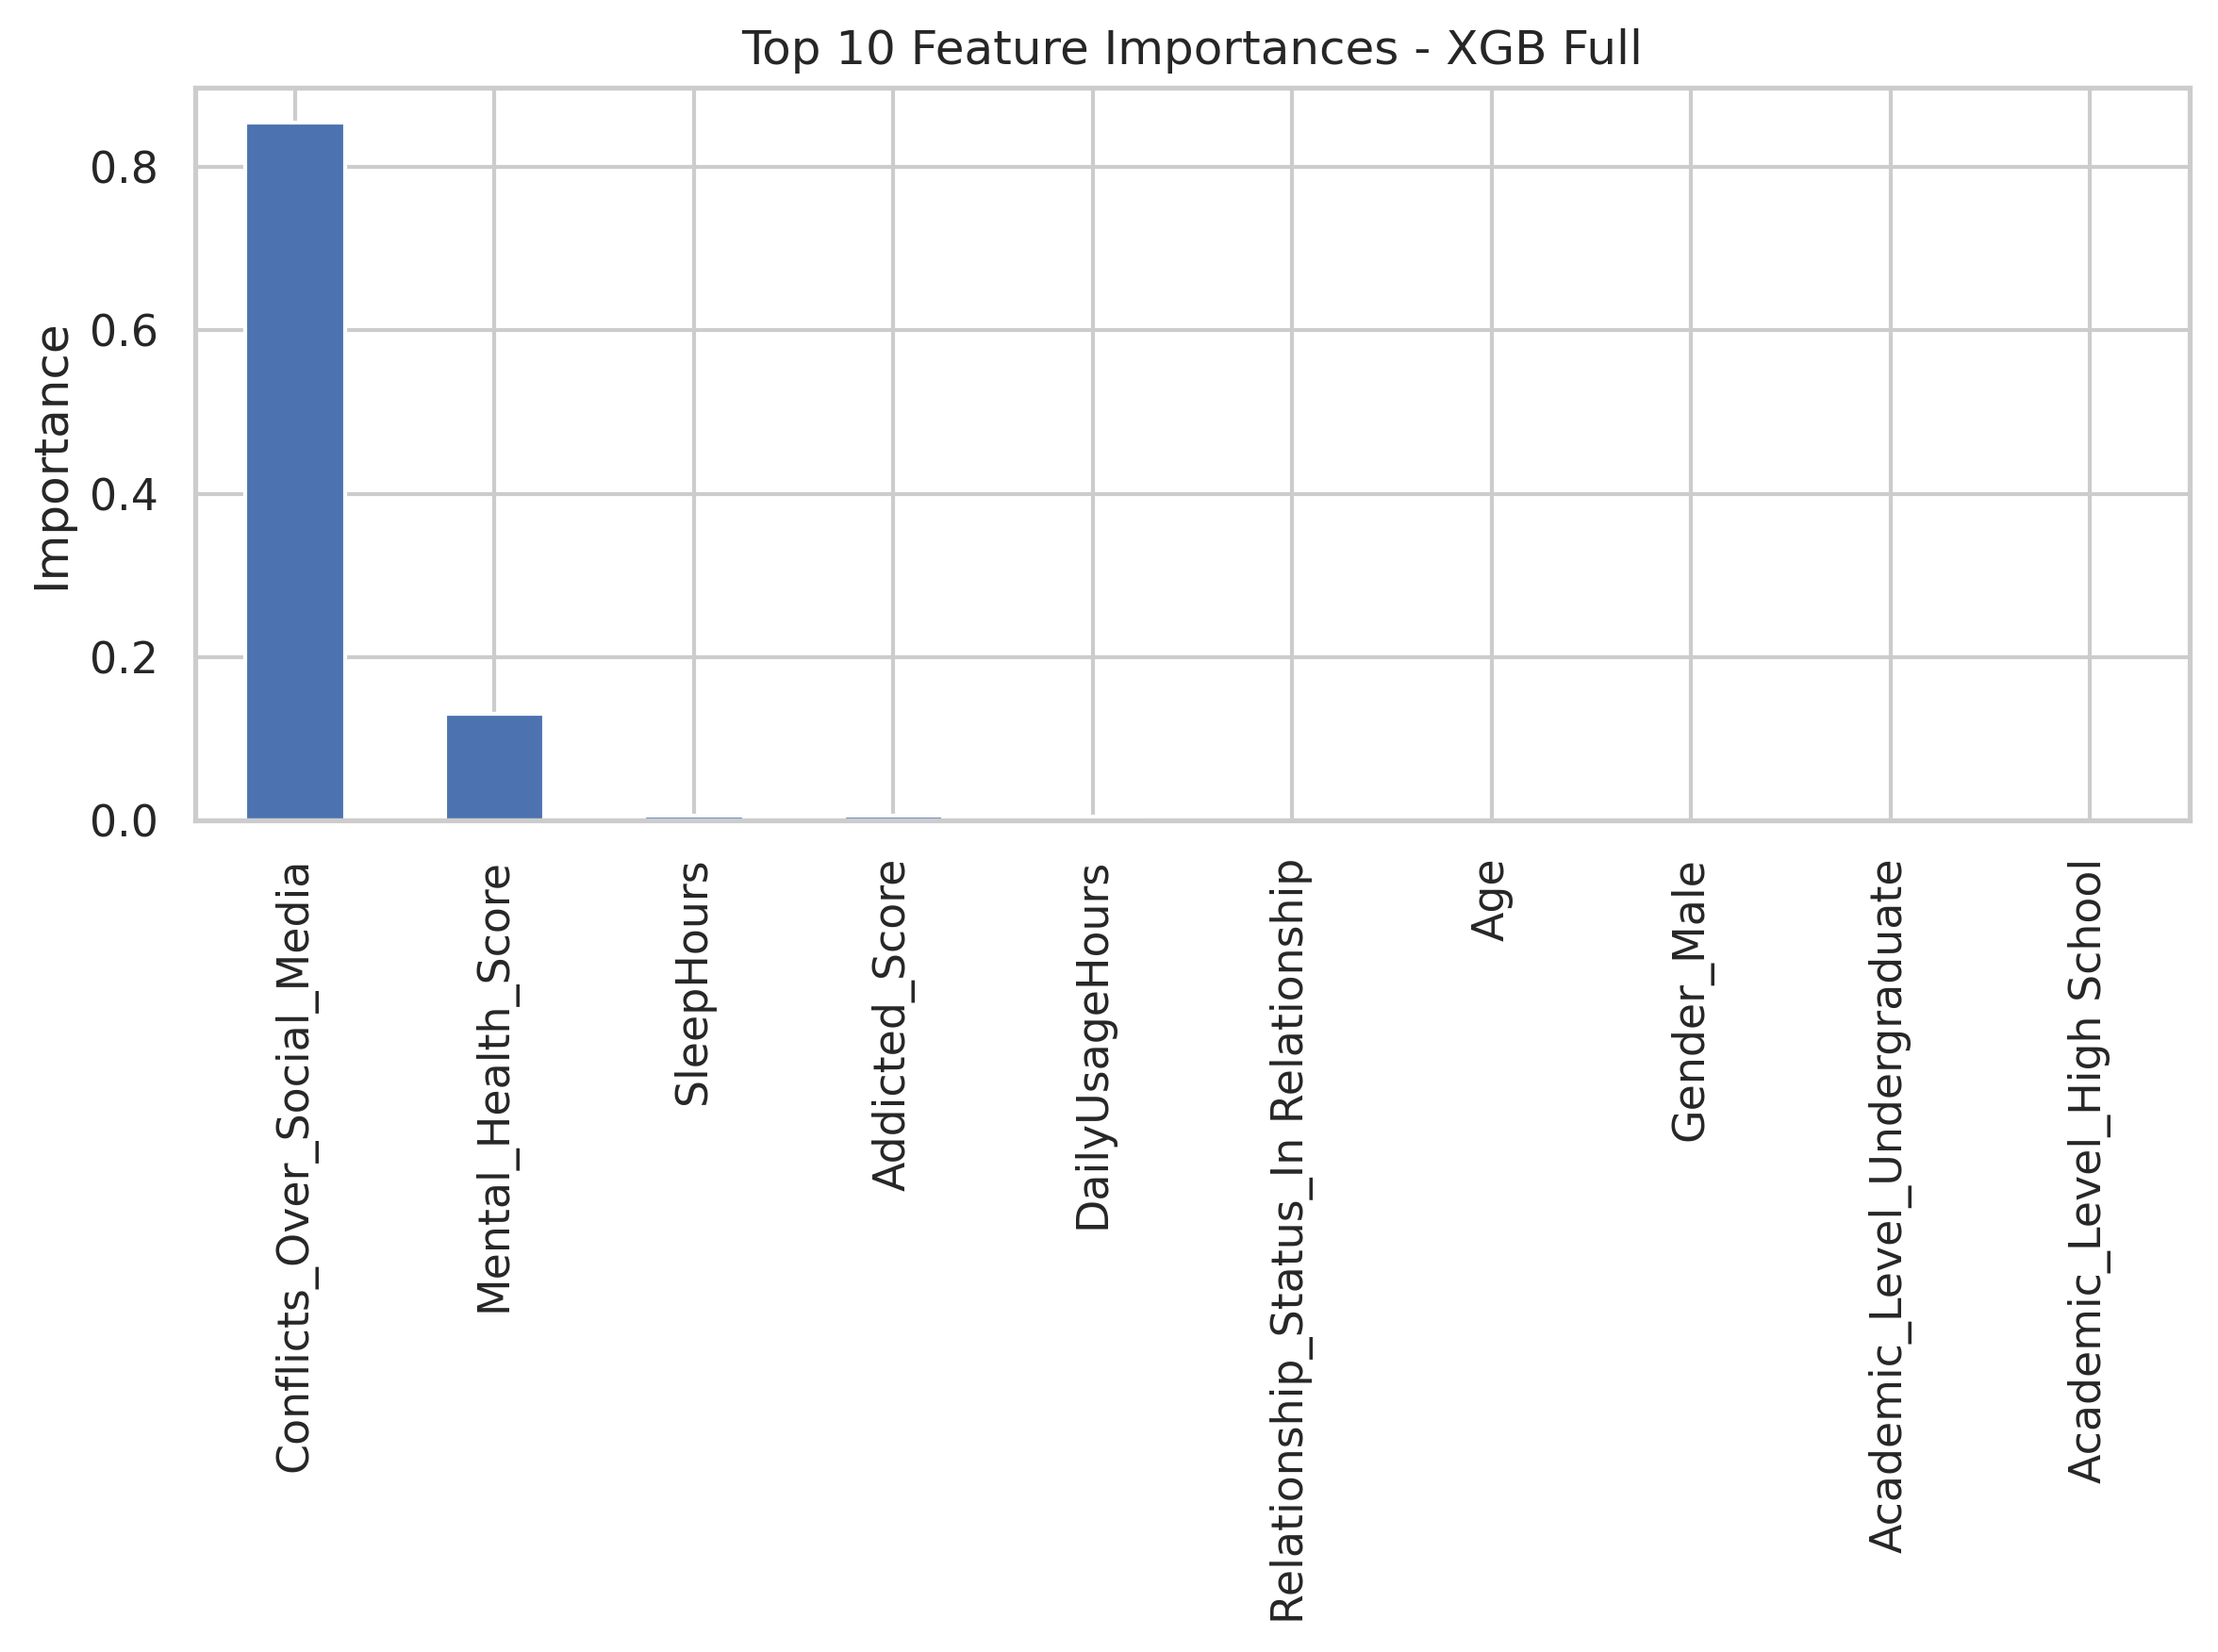

XGB No Both - XGBoost Evaluation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


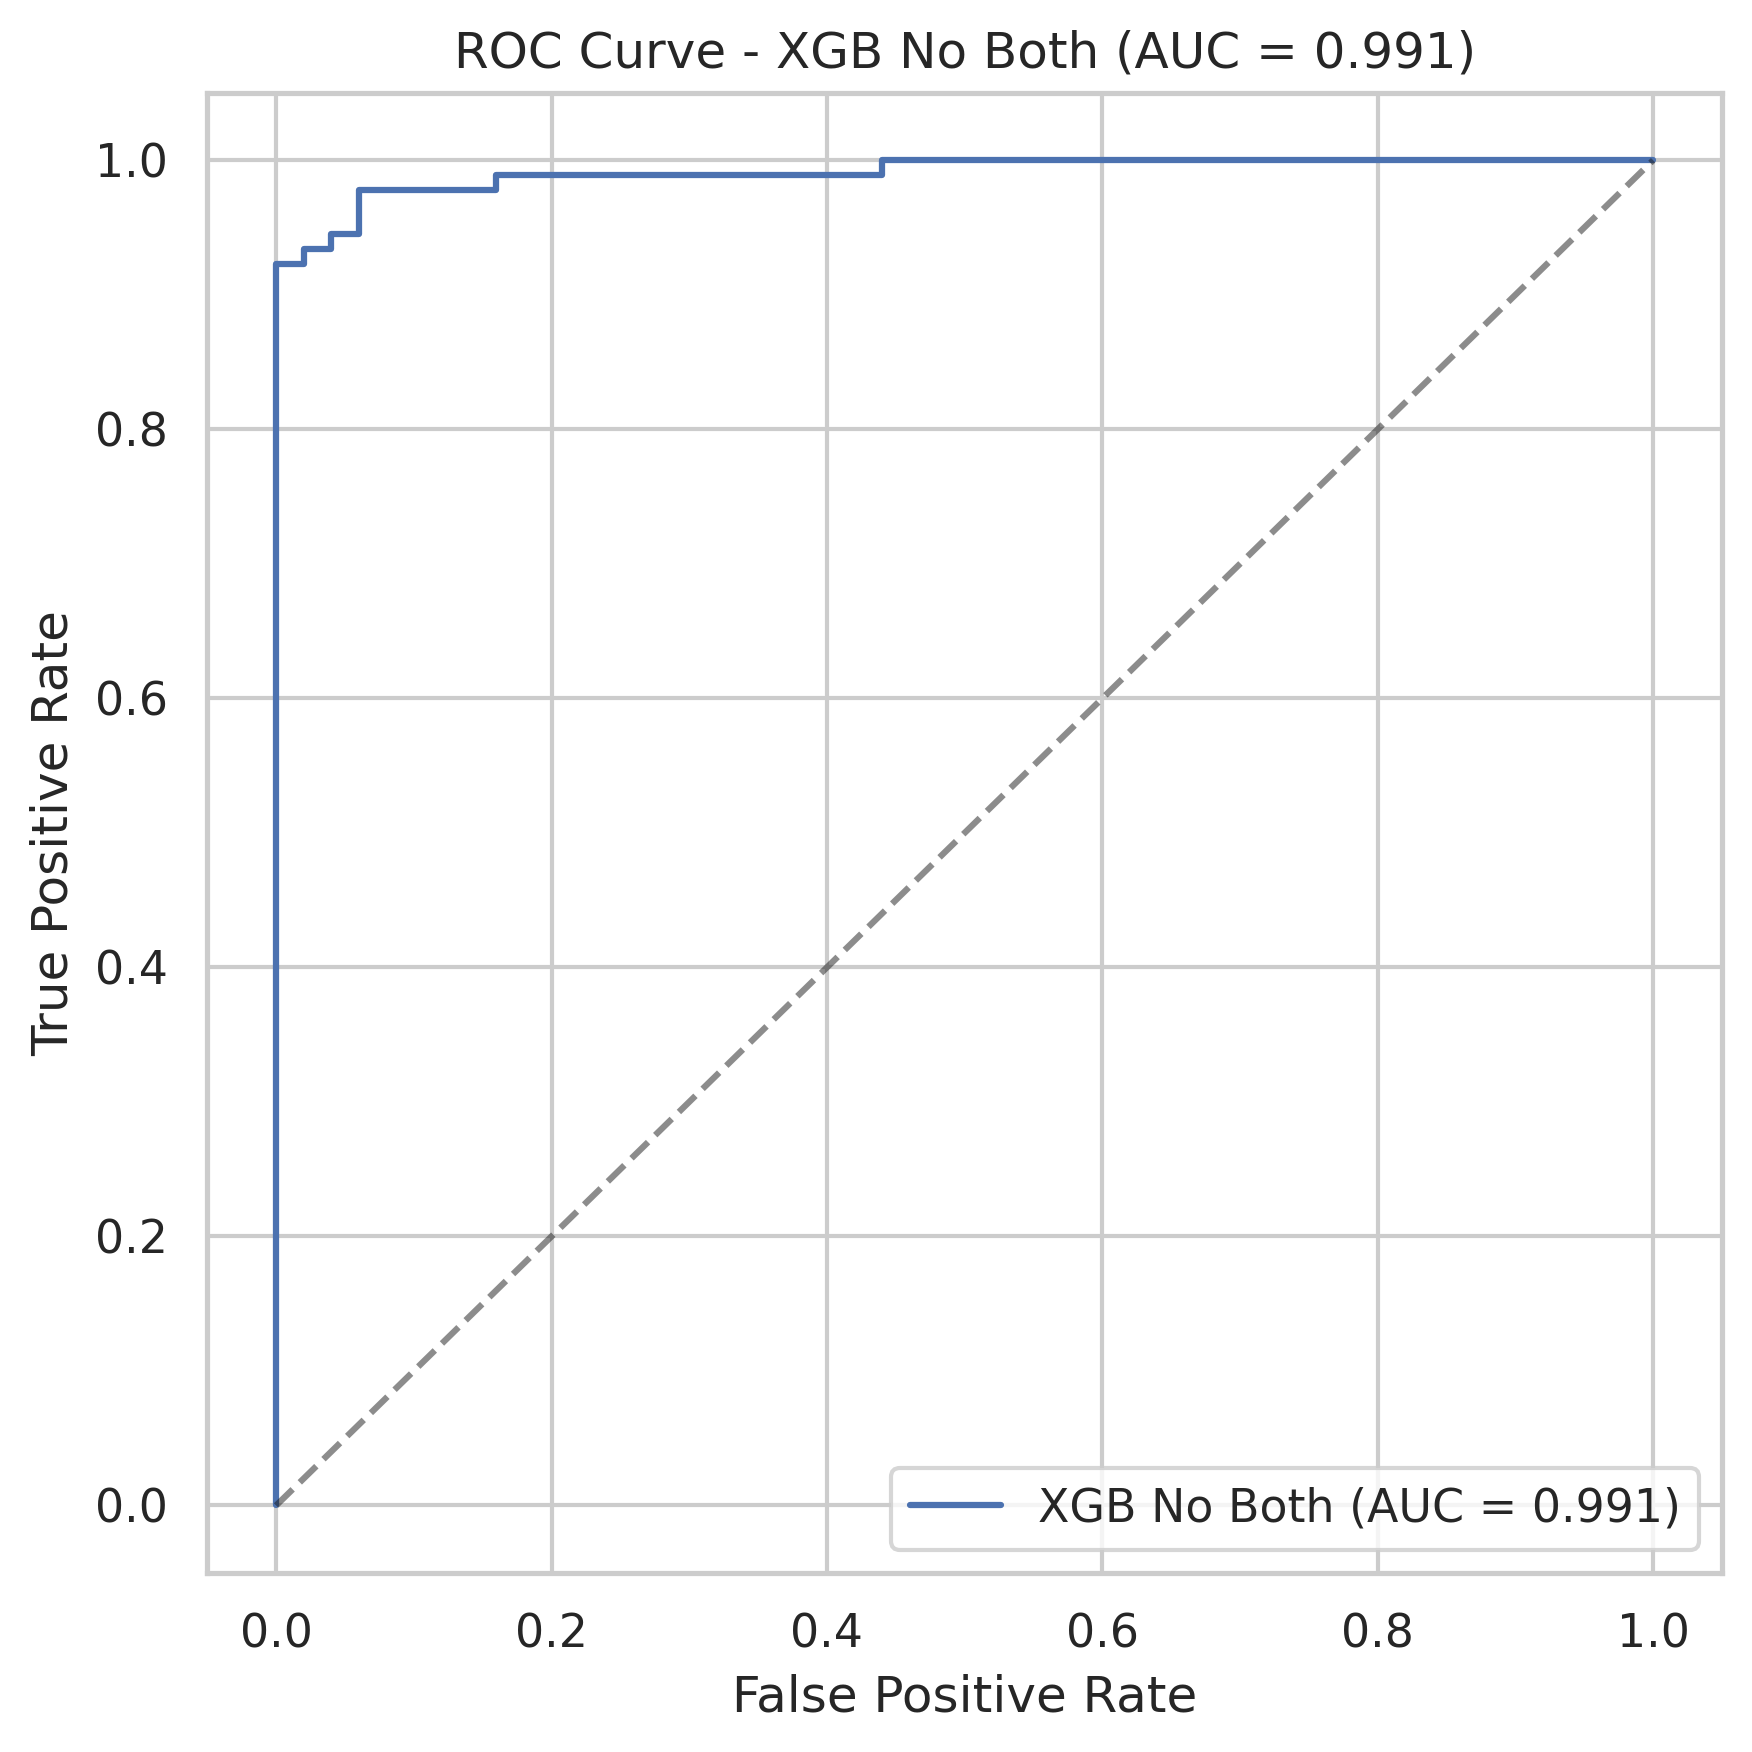

Confusion Matrix:
[[46  4]
 [ 2 89]]
              precision    recall  f1-score   support

          No       0.96      0.92      0.94        50
         Yes       0.96      0.98      0.97        91

    accuracy                           0.96       141
   macro avg       0.96      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141



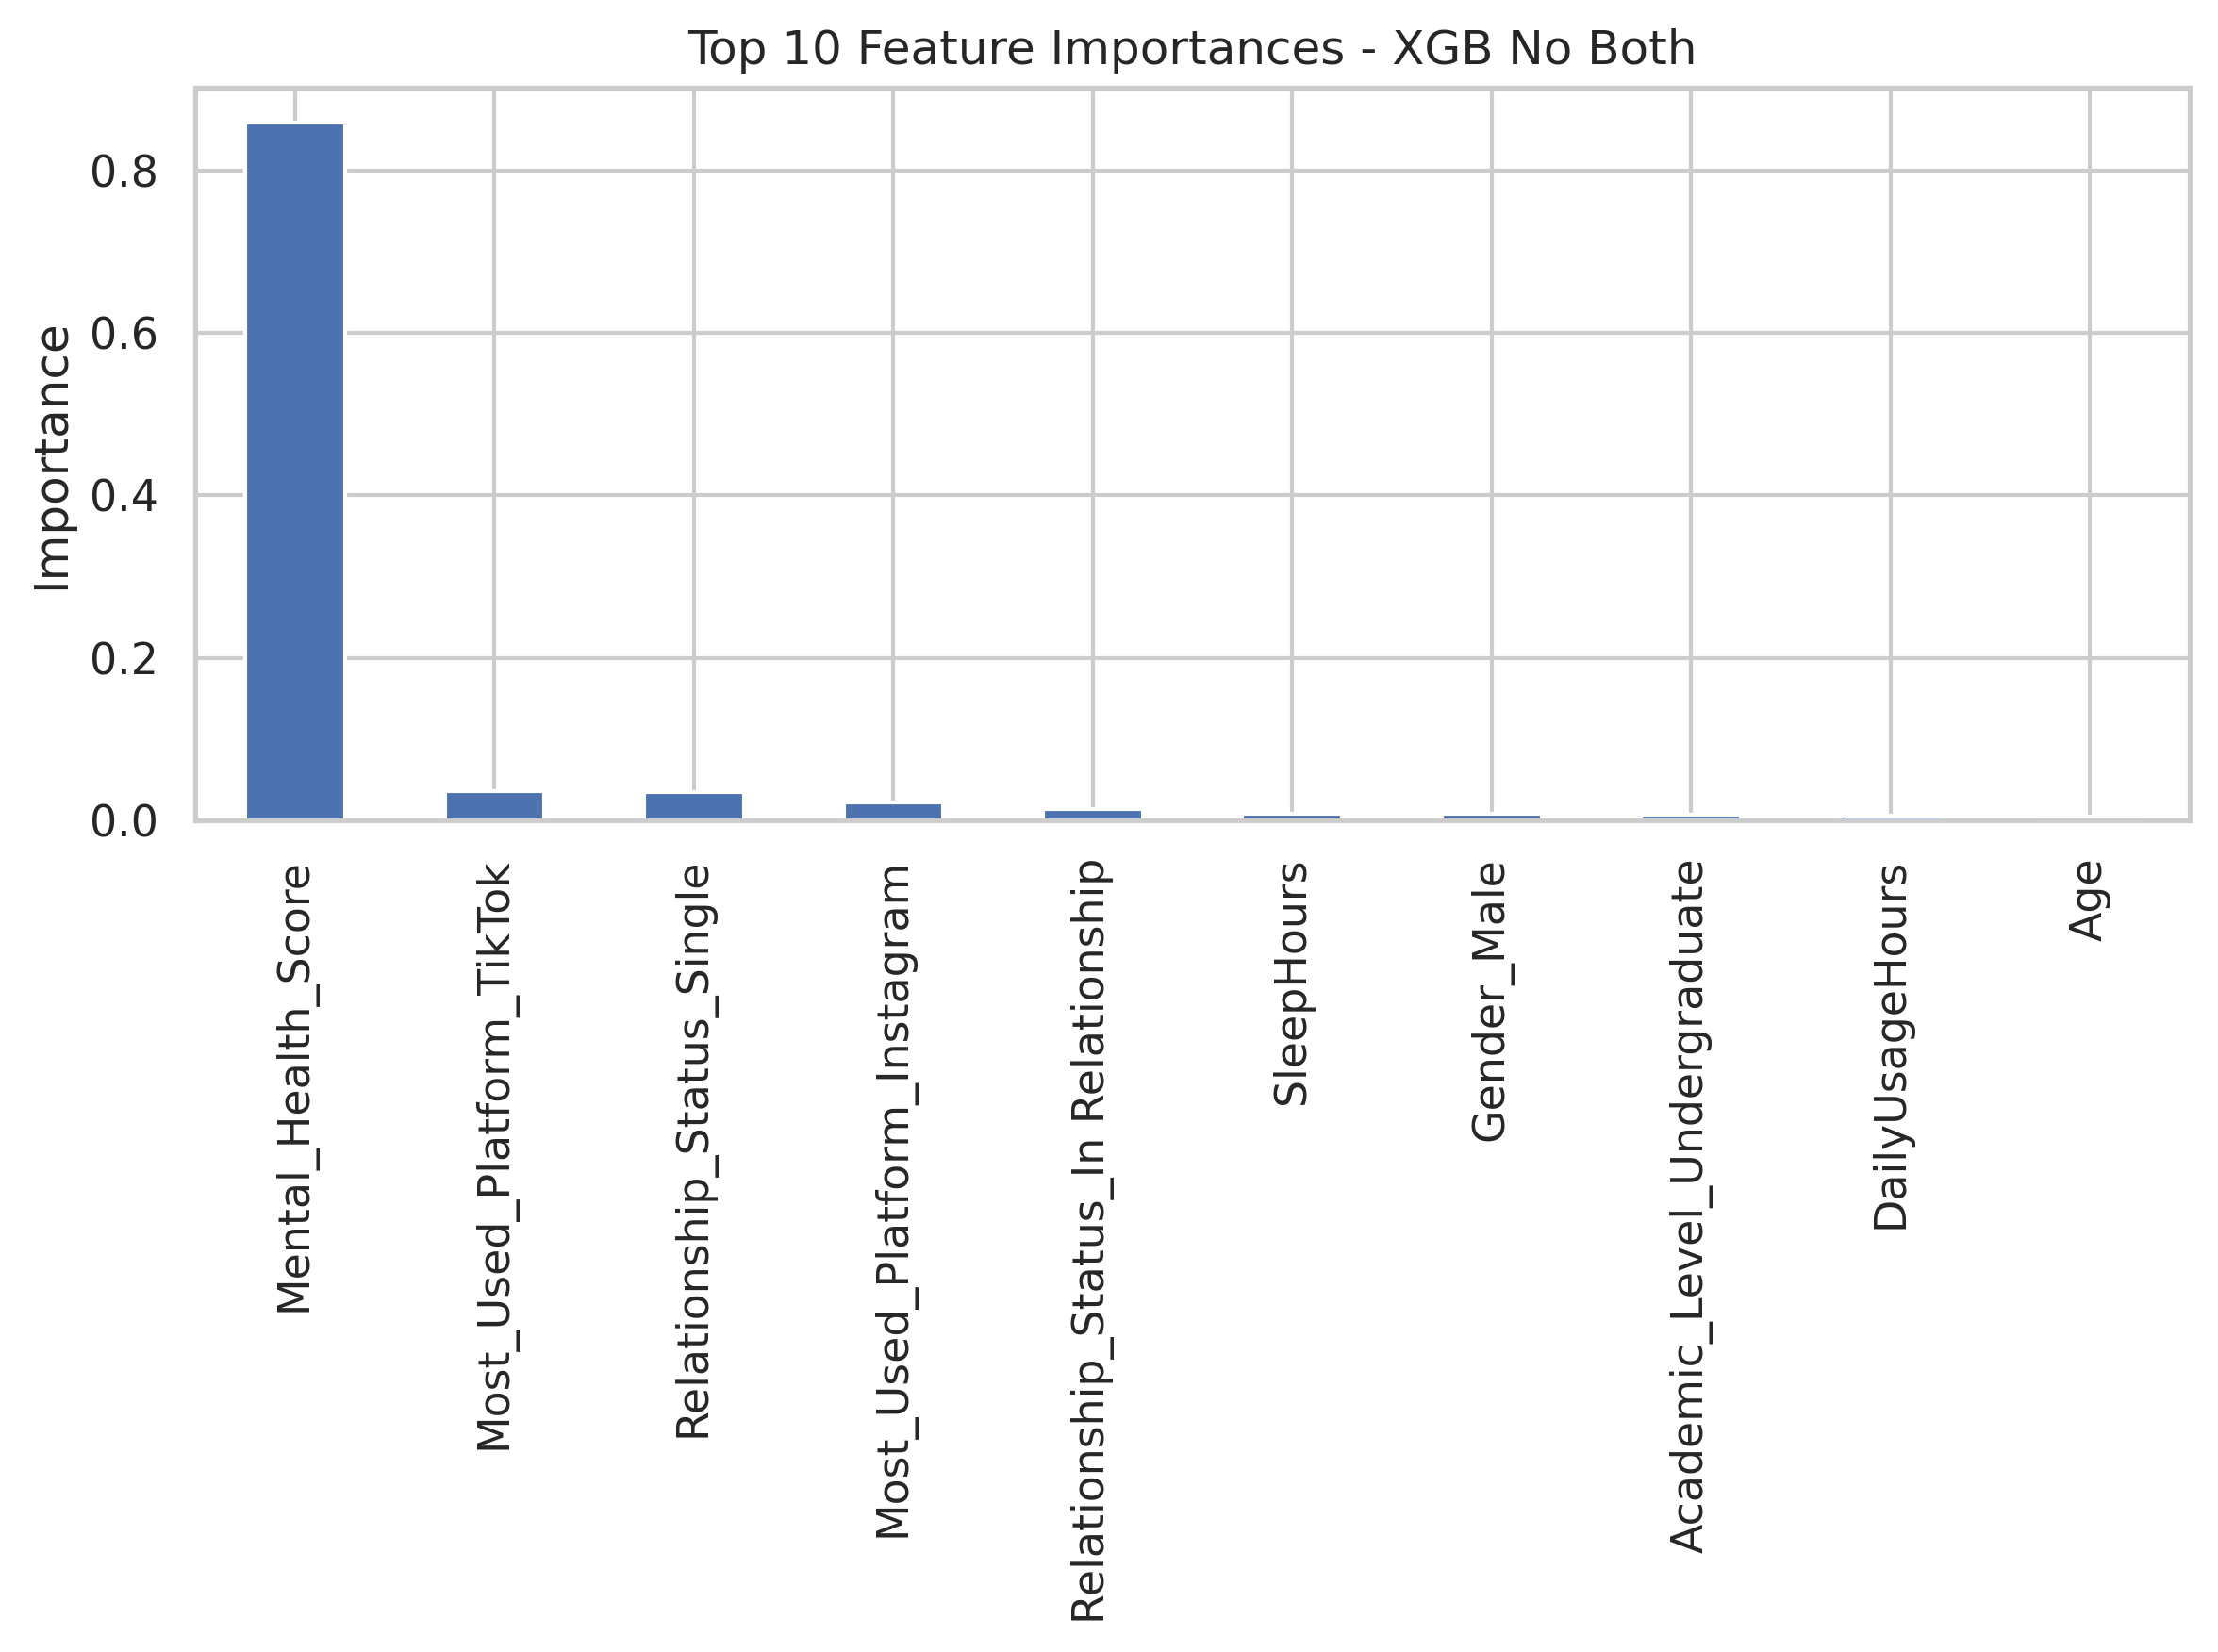

XGB Demographics Only - XGBoost Evaluation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


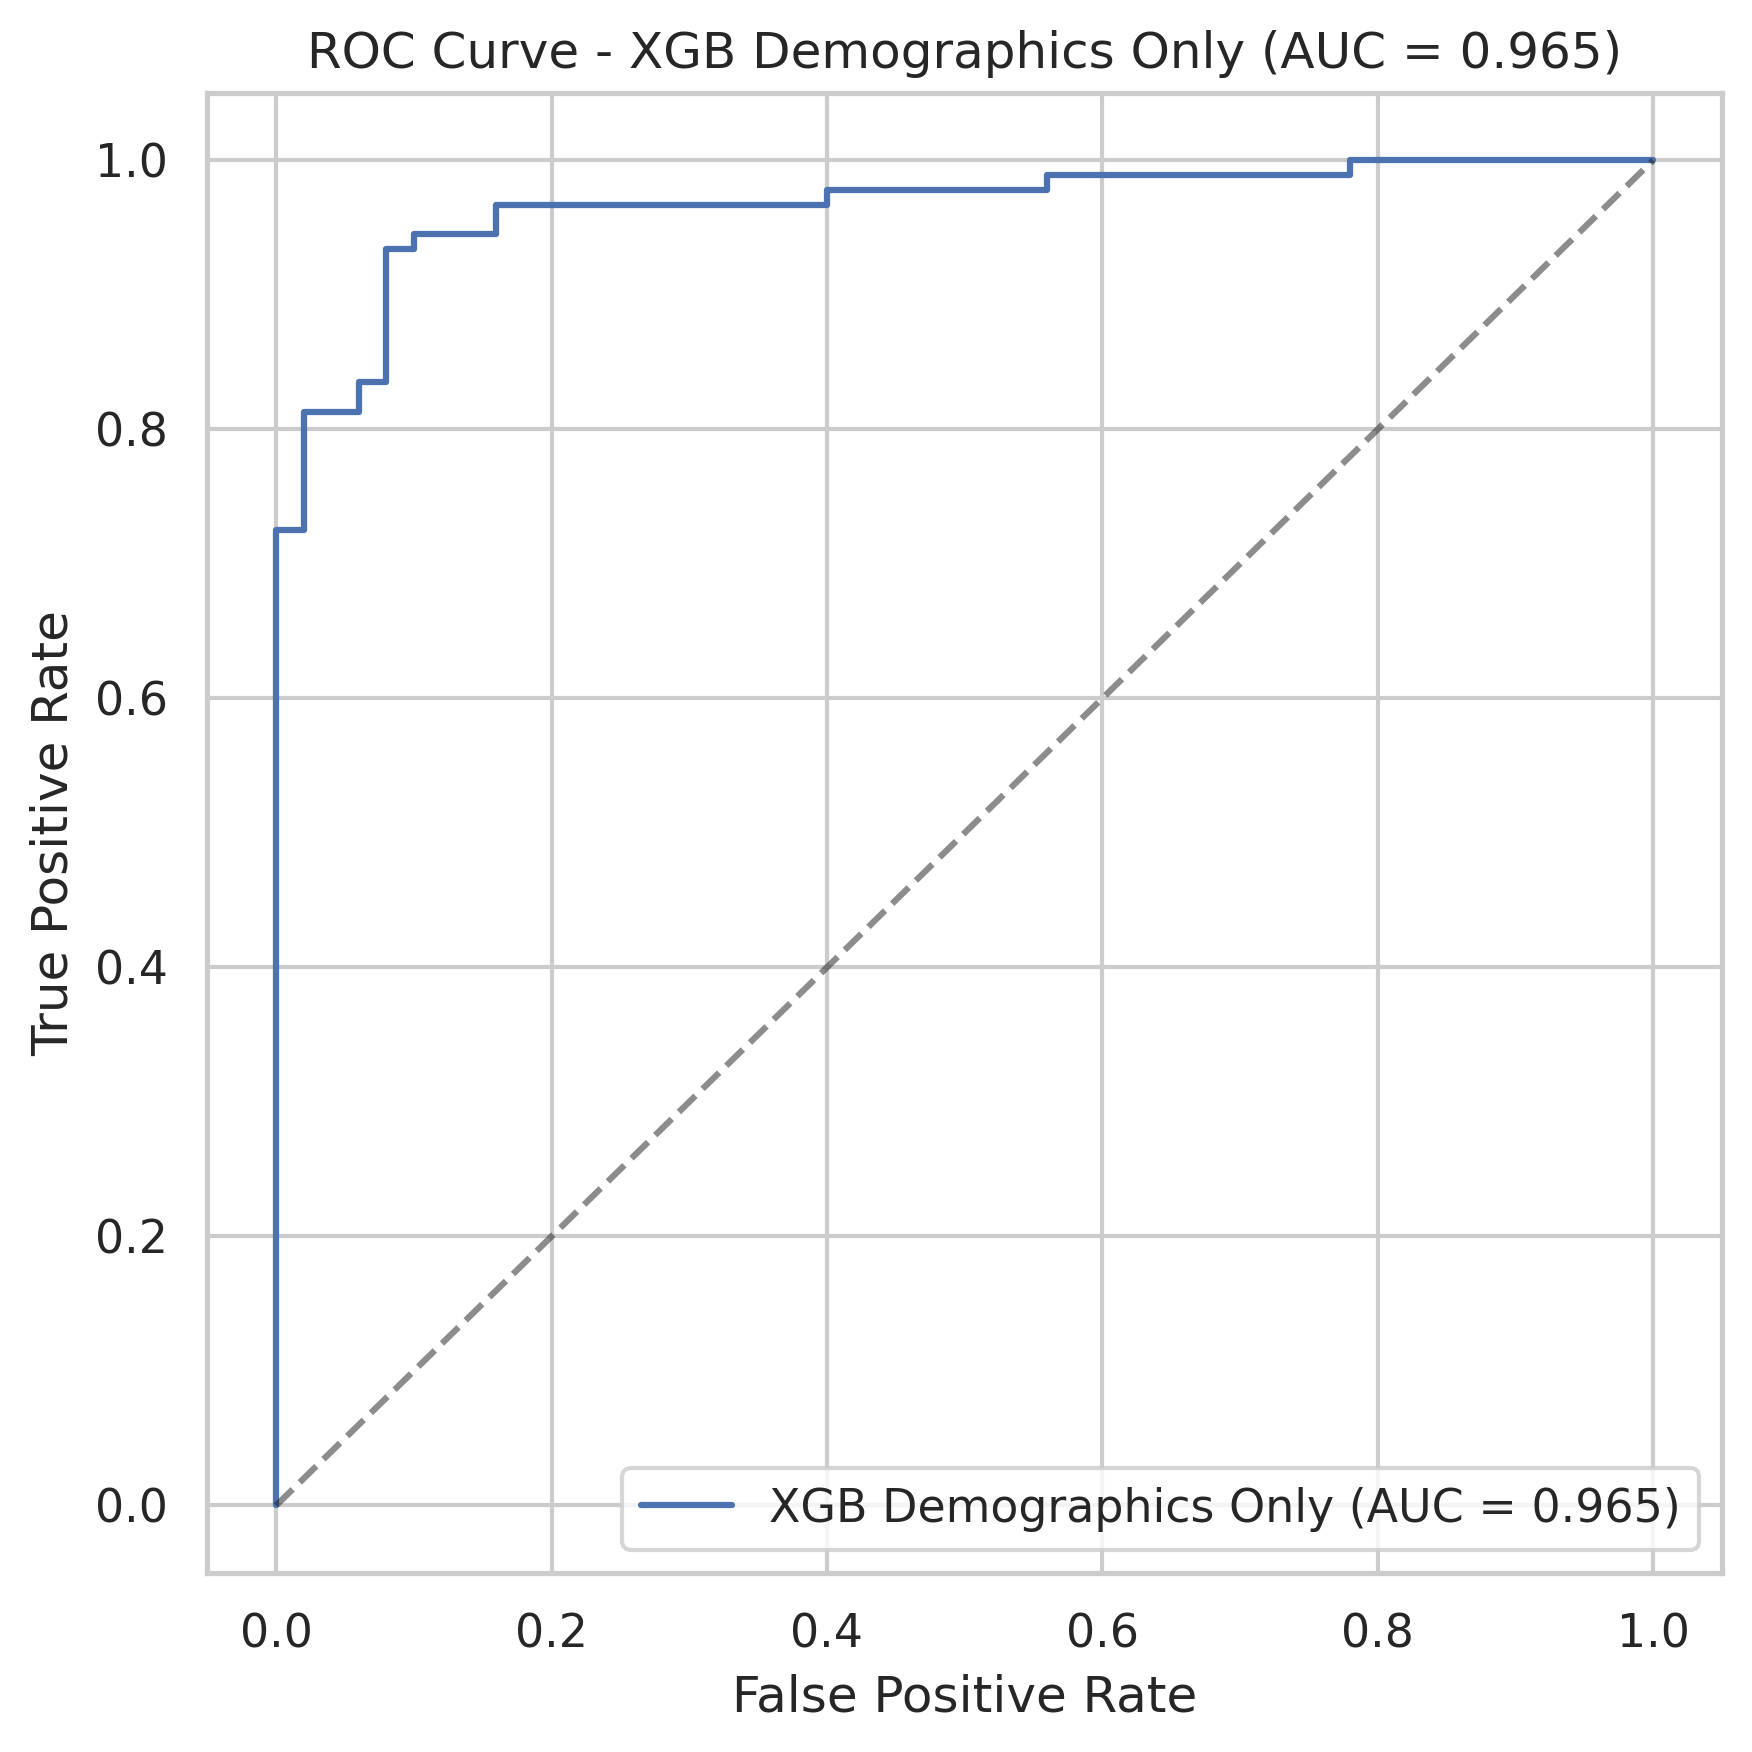

Confusion Matrix:
[[45  5]
 [ 6 85]]
              precision    recall  f1-score   support

          No       0.88      0.90      0.89        50
         Yes       0.94      0.93      0.94        91

    accuracy                           0.92       141
   macro avg       0.91      0.92      0.92       141
weighted avg       0.92      0.92      0.92       141



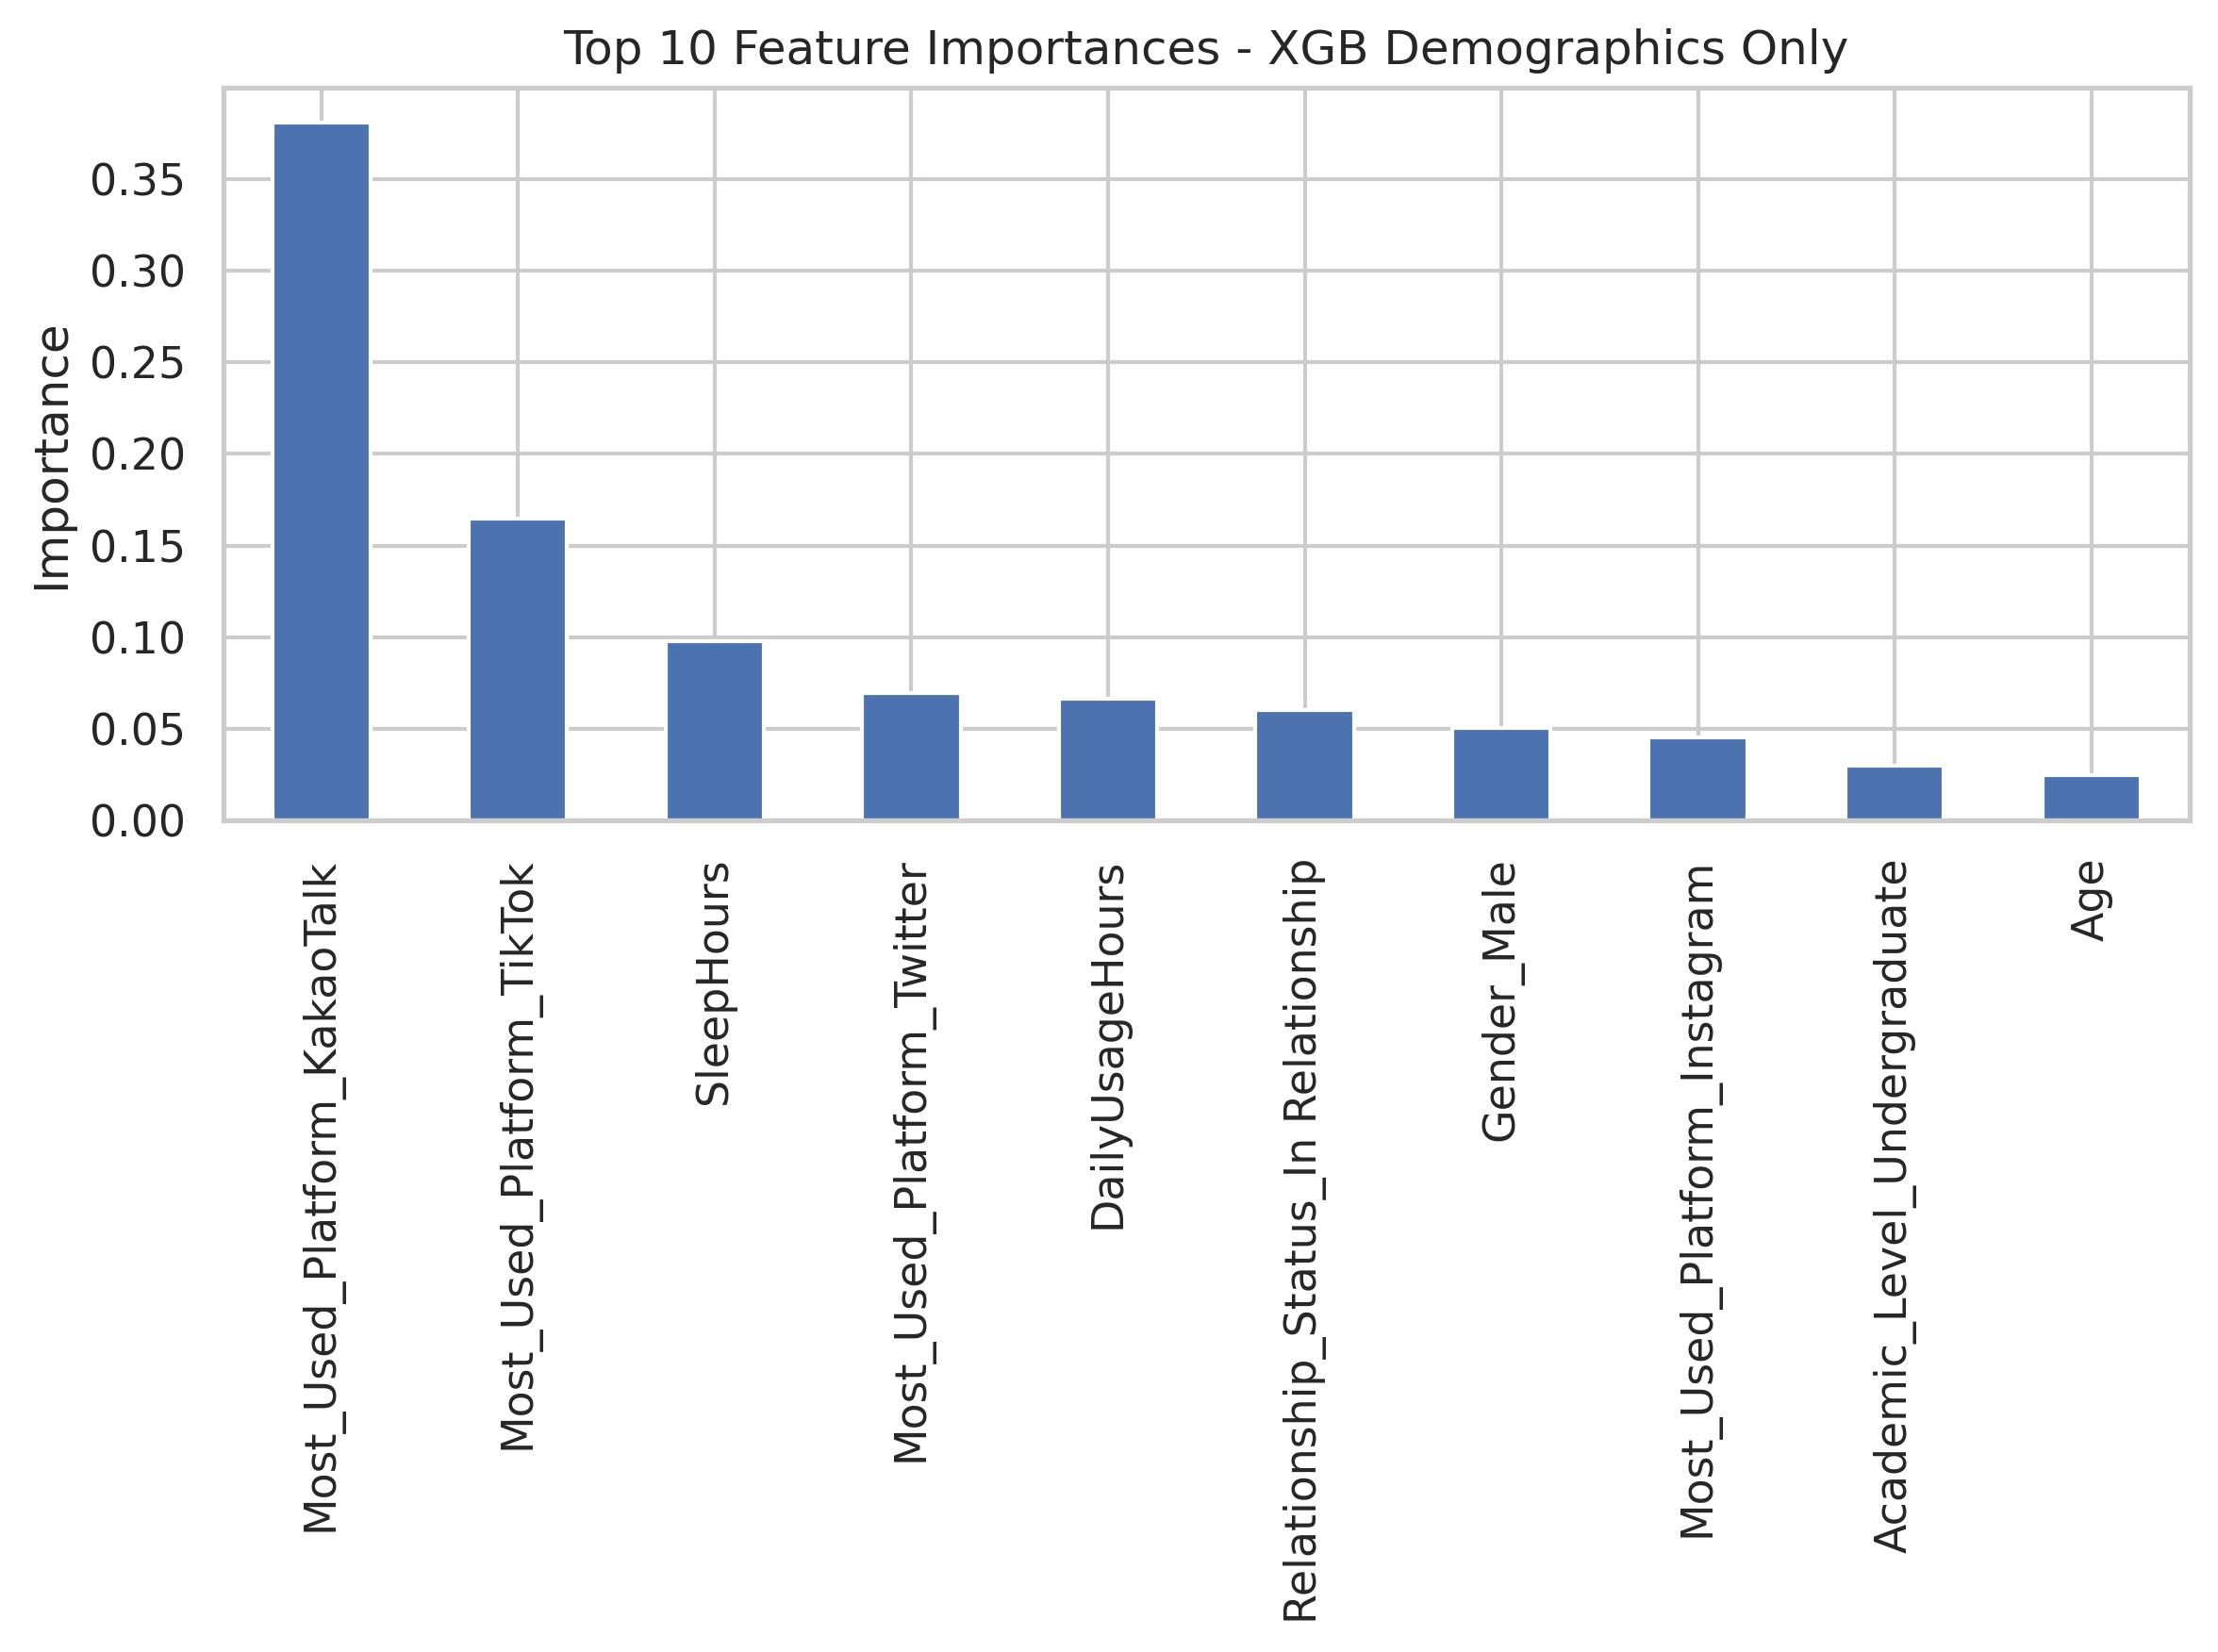

In [ ]:
# Step 27: Execute XGBoost for each dataset variant

evaluate_xgb("XGB Full", X_train, y_train, X_test, y_test)
evaluate_xgb("XGB No Both", X_train_nb, y_train_nb, X_test_nb, y_test_nb)
evaluate_xgb("XGB Demographics Only", X_train_clean, y_train_clean, X_test_clean, y_test_clean)